# Cars Price Prediction in Poland

The automotive market in Poland is dynamic and highly diverse, with thousands of new and used vehicles being listed for sale every day. Prices of cars vary significantly depending on factors such as brand, model, production year, mileage, engine type, power, transmission, equipment level, and overall market trends. 

For both buyers and sellers, accurately estimating the fair market value of a vehicle can be challenging and often relies on subjective assessments or incomplete information.

The goal of this project is to build a machine learning model that predicts car prices in the Polish market based on publicly available vehicle listings. By analyzing historical data and identifying key features that influence pricing, the project aims to deliver a tool capable of generating reliable price estimates.

In [2]:
#Loading the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import optuna
import joblib
import requests
import scipy.stats as scistats
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, learning_curve, GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,  mean_absolute_percentage_error


In [3]:
#Loading the dataset

cars_data = pd.read_csv('../data/Car_sale_ads.csv')

In [4]:
cars_data.head(3)

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.0,...,Manual,coupe,2.0,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.0,...,Automatic,small_cars,3.0,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."


## Data Preprocessing

In [5]:
#Getting some info about dataset
cars_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208304 entries, 0 to 208303
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Index                    208304 non-null  int64  
 1   Price                    208304 non-null  int64  
 2   Currency                 208304 non-null  object 
 3   Condition                208304 non-null  object 
 4   Vehicle_brand            208304 non-null  object 
 5   Vehicle_model            208304 non-null  object 
 6   Vehicle_version          138082 non-null  object 
 7   Vehicle_generation       147860 non-null  object 
 8   Production_year          208304 non-null  int64  
 9   Mileage_km               207321 non-null  float64
 10  Power_HP                 207661 non-null  float64
 11  Displacement_cm3         206338 non-null  float64
 12  Fuel_type                208304 non-null  object 
 13  CO2_emissions            94047 non-null   float64
 14  Driv

In [6]:
#Displaying the description without scientific notation
cars_data.describe().applymap(lambda x: f"{x:.2f}")

C:\Users\Przemek\AppData\Local\Temp\ipykernel_16656\2074403406.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cars_data.describe().applymap(lambda x: f"{x:.2f}")


,Index,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number
count,208304.00,208304.00,208304.00,207321.00,207661.00,206338.00,94047.00,206817.00
mean,104151.50,63053.83,2012.10,150276.76,151.84,1882.57,319156.38,4.64
std,60132.33,86659.67,7.00,2937446.81,77.68,729.61,72913958.71,0.77
min,0.00,500.00,1915.00,1.00,1.00,400.00,1.00,1.00
25%,52075.75,17800.00,2008.00,53000.00,105.00,1461.00,120.00,5.00
50%,104151.50,35700.00,2013.00,144566.00,136.00,1798.00,140.00,5.00
75%,156227.25,75990.00,2017.00,206000.00,172.00,1997.00,164.00,5.00
max,208303.00,6999000.00,2021.00,1111111111.00,1398.00,8400.00,20000000000.00,55.00


In [7]:
cars_data.columns

Index(['Index', 'Price', 'Currency', 'Condition', 'Vehicle_brand',
       'Vehicle_model', 'Vehicle_version', 'Vehicle_generation',
       'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3',
       'Fuel_type', 'CO2_emissions', 'Drive', 'Transmission', 'Type',
       'Doors_number', 'Colour', 'Origin_country', 'First_owner',
       'First_registration_date', 'Offer_publication_date', 'Offer_location',
       'Features'],
      dtype='object')

In [8]:
#How many NaN values are in the dataset
cars_data.isna().sum()

Index                           0
Price                           0
Currency                        0
Condition                       0
Vehicle_brand                   0
Vehicle_model                   0
Vehicle_version             70222
Vehicle_generation          60444
Production_year                 0
Mileage_km                    983
Power_HP                      643
Displacement_cm3             1966
Fuel_type                       0
CO2_emissions              114257
Drive                       15076
Transmission                  479
Type                            0
Doors_number                 1487
Colour                          0
Origin_country              89992
First_owner                143210
First_registration_date    121859
Offer_publication_date          0
Offer_location                  0
Features                        0
dtype: int64

In [9]:
#Checking amount of duplicates in 'Currency' column
print((cars_data['Currency'] != 'PLN').sum())

#Expolring is there some other curriencies
print(cars_data.loc[cars_data['Currency'] != 'PLN', 'Currency'].unique())

270
['EUR']


There is currency other than PLN (EURO), so we need to convert the price to PLN.

In [10]:
def get_current_eur_pln_rate():
    url = "http://api.nbp.pl/api/exchangerates/rates/a/eur/?format=json"
    
    try:
        response = requests.get(url, timeout=5) 
        response.raise_for_status()
        data = response.json()
        
        rate = data['rates'][0]['mid']
        print(f"Current exchange rate was loaded from NBP: {rate}")
        return rate
        
    except Exception as e:
        print(f"There was a failure with loading exchange rate ({e}). Default value was taken.")
        return 4.30
    
EUR_to_PLN = get_current_eur_pln_rate()

cars_data['price_PLN'] = cars_data.apply(
    lambda row: row['Price'] * EUR_to_PLN if row['Currency'] == 'EUR' else row['Price'],
    axis=1
)

Current exchange rate was loaded from NBP: 4.2119


In [11]:
#Removing columns 'CO2_emissions', 'First_registration_date', 'Vehicle_version', 'Vehicle_generation'
#There are too many NaN values in these columns and they have small impact on car price overall
cols_to_drop = ['CO2_emissions', 'First_registration_date', 'Vehicle_version', 'Vehicle_generation']

cars_data_rem = cars_data.drop(columns=cols_to_drop)

In [12]:
#Replacing some NaN values that will be useful later

#In First_owner column are only 'Yes' and 'NaN' values
print(cars_data_rem.loc[cars_data_rem['First_owner'] != 'Yes', 'First_owner'].unique())

cars_data_rem['First_owner'] = cars_data_rem['First_owner'].fillna('Unknown')
cars_data_rem['Origin_country'] = cars_data_rem['Origin_country'].fillna('Unknown')

[nan]


In [13]:
#Transmission column is important in case of predicting cars price but NaN's represents 
#negligible percent of whole column so I remove those rows with NaN
cars_data_rem = cars_data_rem.dropna(subset=['Transmission'])

In [14]:
#extracting year from Offer_publication_date
cars_data_rem['Offer_publication_date'] = pd.to_datetime(cars_data_rem['Offer_publication_date'], format='%d/%m/%Y')
cars_data_rem['Year_publication'] = cars_data_rem['Offer_publication_date'].dt.year

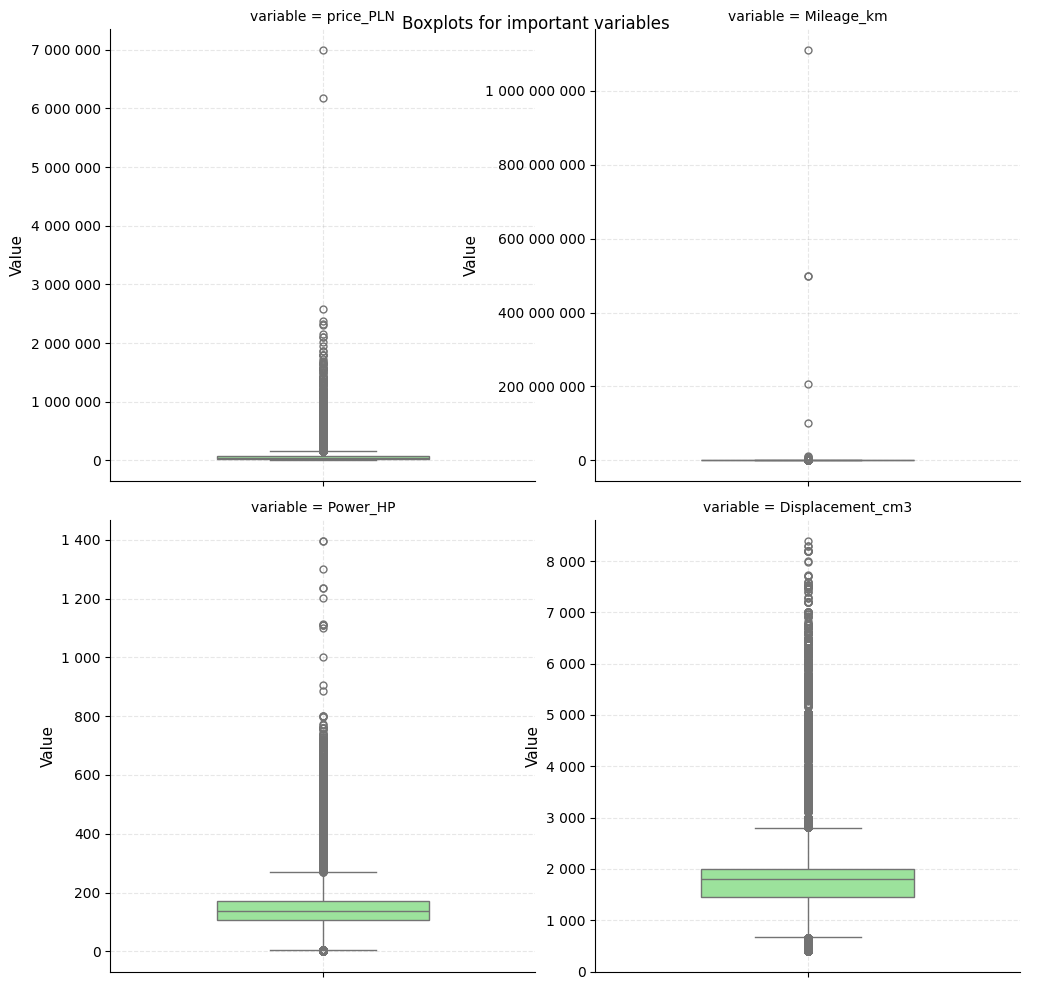

In [15]:
#Displaying boxplots
cols_to_boxplot = ['price_PLN', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

plots = sns.catplot(
    kind='box',
    data=cars_data_rem[cols_to_boxplot].melt(),
    y='value',
    col='variable',
    col_wrap=2,
    sharey=False,
    color='lightgreen',
    width=0.5
)

for ax in plots.axes.flat:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', ' ')))
    ax.set_ylabel('Value', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlabel('')

plt.savefig('../images/Boxplots_for_various_features', dpi=300, bbox_inches='tight')
plt.suptitle('Boxplots for important variables')
plt.show()

### Boxplot Analysis for Key Variables

### Price (price_PLN) - Top Left
The boxplot on the top left shows price_PLN values. Most of them fit between 0-100,000 PLN, but there are some cars that cost more than 500,000 PLN. These prices are probably from the premium segment, while values over 6 million PLN likely represent rare supercars or collector vehicles. However, such extreme values can distort our analysis of the typical used car market, so they should be removed. Additionally, extremely low prices (below 2,500 PLN) might indicate damaged vehicles or data entry errors.

### Mileage (Mileage_km) - Top Right
The boxplot on the top right displays mileage distribution. The majority of vehicles show mileage between 0-200,000 km, which is typical for used cars on the Polish market. However, there are significant outliers exceeding 500,000 km, with some extreme values reaching over 1 million km. Such high mileage is physically unrealistic for passenger vehicles and likely indicates data entry errors (possibly confusion between miles and kilometers) or fraudulent listings. These values should be removed to ensure data quality.

### Power (Power_HP) - Bottom Left
The bottom left boxplot presents engine power distribution. Most vehicles have power ranging from approximately 80-200 HP, which aligns with the mainstream car market. The median appears to be around 120-150 HP. However, there are outliers reaching 1,300-1,400 HP, representing hypercars and supercars. While these values may be legitimate, they represent less than 0.1% of the market and can skew predictive models. For typical market analysis, it's reasonable to cap power at around 1000 HP.

### Engine Displacement (Displacement_cm3) - Bottom Right
The bottom right boxplot shows engine displacement distribution. The typical range appears to be 1,200-2,500 cm³, which is standard for passenger cars in Europe. The interquartile range (the box itself) is relatively narrow, indicating consistency in most vehicles. However, outliers exceeding 7,000-8,500 cm³ are present, which typically represent American V8 engines (muscle cars, trucks) or specialty vehicles. For a focused analysis of the mainstream European car market, these extreme values should be filtered out.

In [16]:
#Based on the boxplot and the description let's cut some values 
cars_data_out = cars_data_rem.copy()

cars_data_out = cars_data_out.loc[(cars_data_out['price_PLN'] > 2500) & (cars_data_out['price_PLN'] < 3000000)]
cars_data_out = cars_data_out.loc[cars_data_out['Mileage_km'] < 800000]
cars_data_out = cars_data_out.loc[(cars_data_out['Power_HP'] > 20) & (cars_data_out['Power_HP'] < 800)]
cars_data_out = cars_data_out.loc[(cars_data_out['Displacement_cm3'] > 200) & (cars_data_out['Displacement_cm3'] < 7000)]



## Exploratory Data Analysis

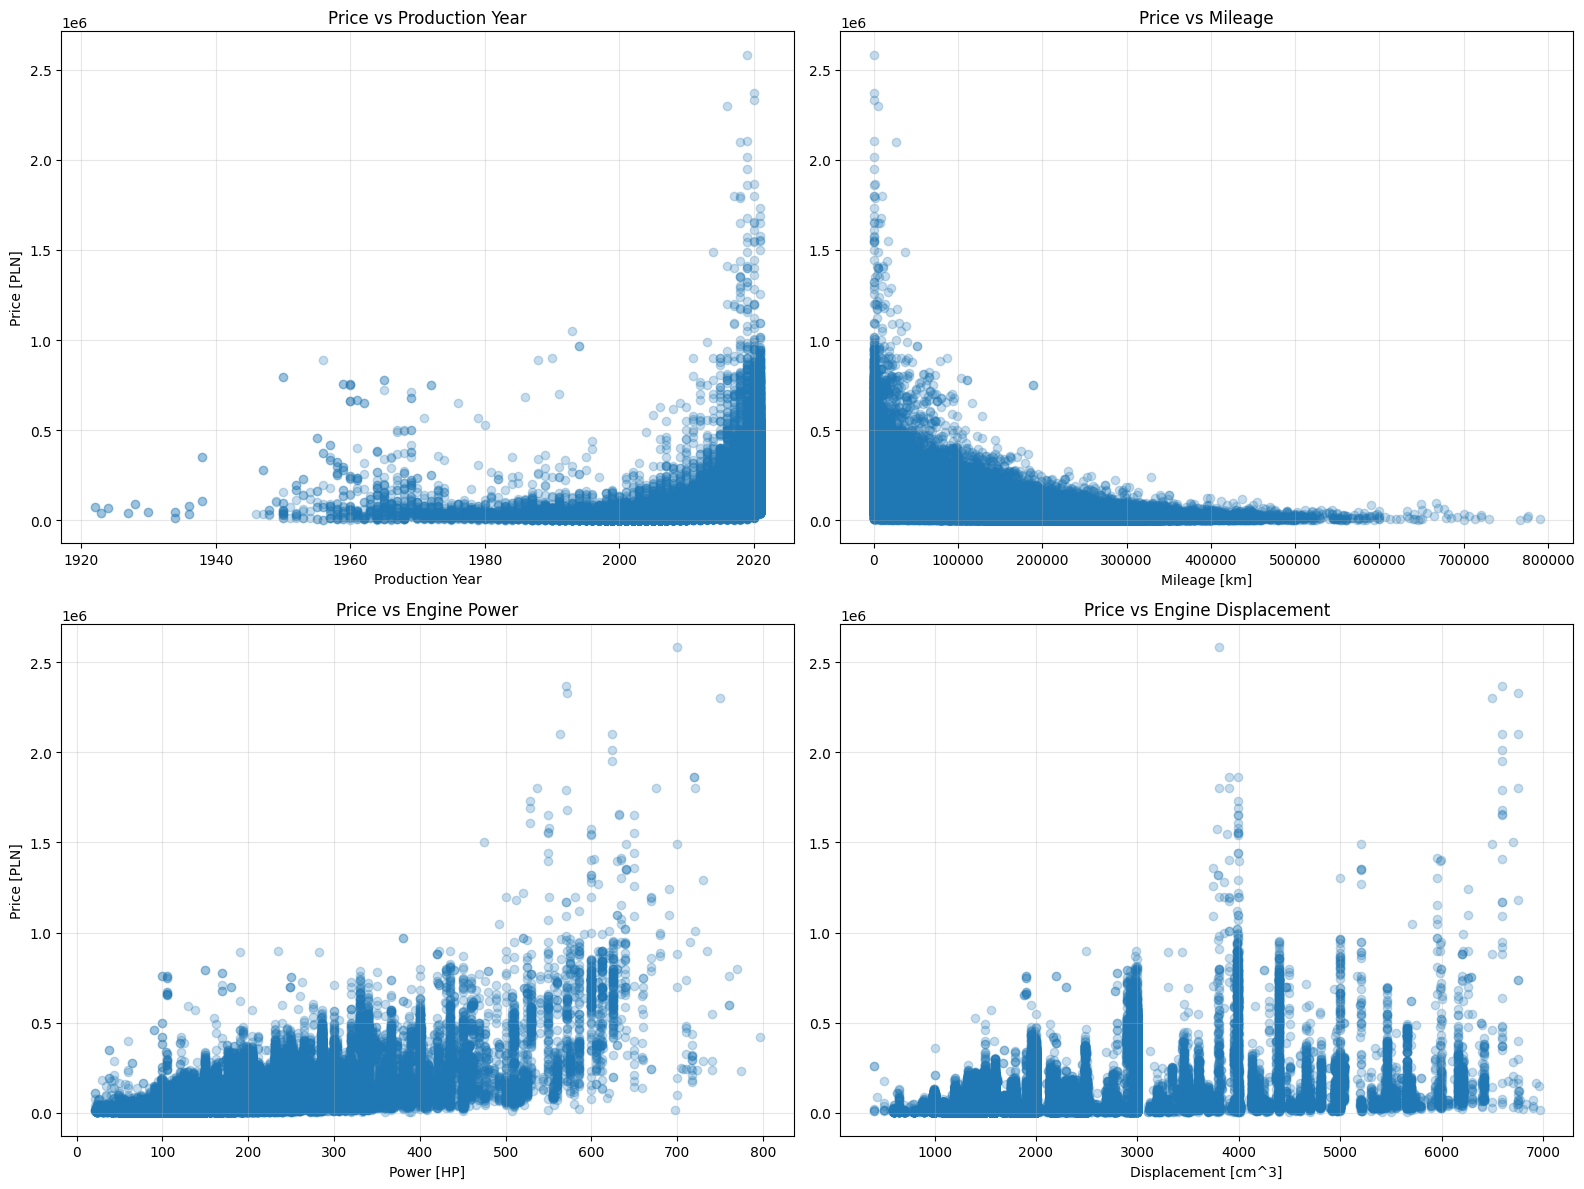

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(16,12))

ax[0,0].scatter(cars_data_out['Production_year'], cars_data_out['price_PLN'],
                alpha=0.25)
ax[0,0].set_title('Price vs Production Year')
ax[0,0].set_xlabel('Production Year')
ax[0,0].set_ylabel('Price [PLN]')

ax[0,1].scatter(cars_data_out['Mileage_km'], cars_data_out['price_PLN'],
                alpha=0.25)
ax[0,1].set_xlabel('Mileage [km]')
ax[0,1].set_title('Price vs Mileage')

ax[1,0].scatter(cars_data_out['Power_HP'], cars_data_out['price_PLN'],
                alpha=0.25)
ax[1,0].set_title('Price vs Engine Power')
ax[1,0].set_xlabel('Power [HP]')
ax[1,0].set_ylabel('Price [PLN]')

ax[1,1].scatter(cars_data_out['Displacement_cm3'], cars_data_out['price_PLN'],
                alpha=0.25)
ax[1,1].set_xlabel('Displacement [cm^3]')
ax[1,1].set_title('Price vs Engine Displacement')

for a in ax.flat:
    a.grid(alpha=0.3)
    a.set_xlabel(a.get_xlabel())

plt.tight_layout()
plt.savefig('../images/Scatterplots_relations_clean.png', dpi=300)
plt.show()

**Price vs Production Year:**

The plot shows a clear upward trend in car prices as the production year increases. Prices remained relatively stable for older cars, but starting around 2015, newer models began exhibiting significantly higher prices. This suggests that modern vehicles—likely with better technology, safety features, and demand—command a premium.

**Price vs Mileage:**

There is a strong inverse relationship between mileage and price. Cars with lower mileage typically have higher prices, reflecting lower wear and longer remaining lifespan. A large concentration of vehicles appears around 180,000 km, but their prices vary widely, likely due to differences in brand, condition, equipment, and model.

**Price vs Power (HP):**
The relationship indicates that cars with higher horsepower generally have higher prices. High-performance vehicles (over 500 HP) show the widest spread in prices, which likely reflects variations in luxury level, brand reputation, and rarity of these models.

**Price vs Engine Displacement (cm³):**
The plot shows that most cars cluster around typical engine sizes such as 1,600–2,000 cm³ or 3,000 cm³. Prices tend to increase with engine displacement, but the relationship is not as smooth as for power. Very large engines (around 7,000 cm³) are rare, as expected, and appear mostly in high-end or specialized vehicles.

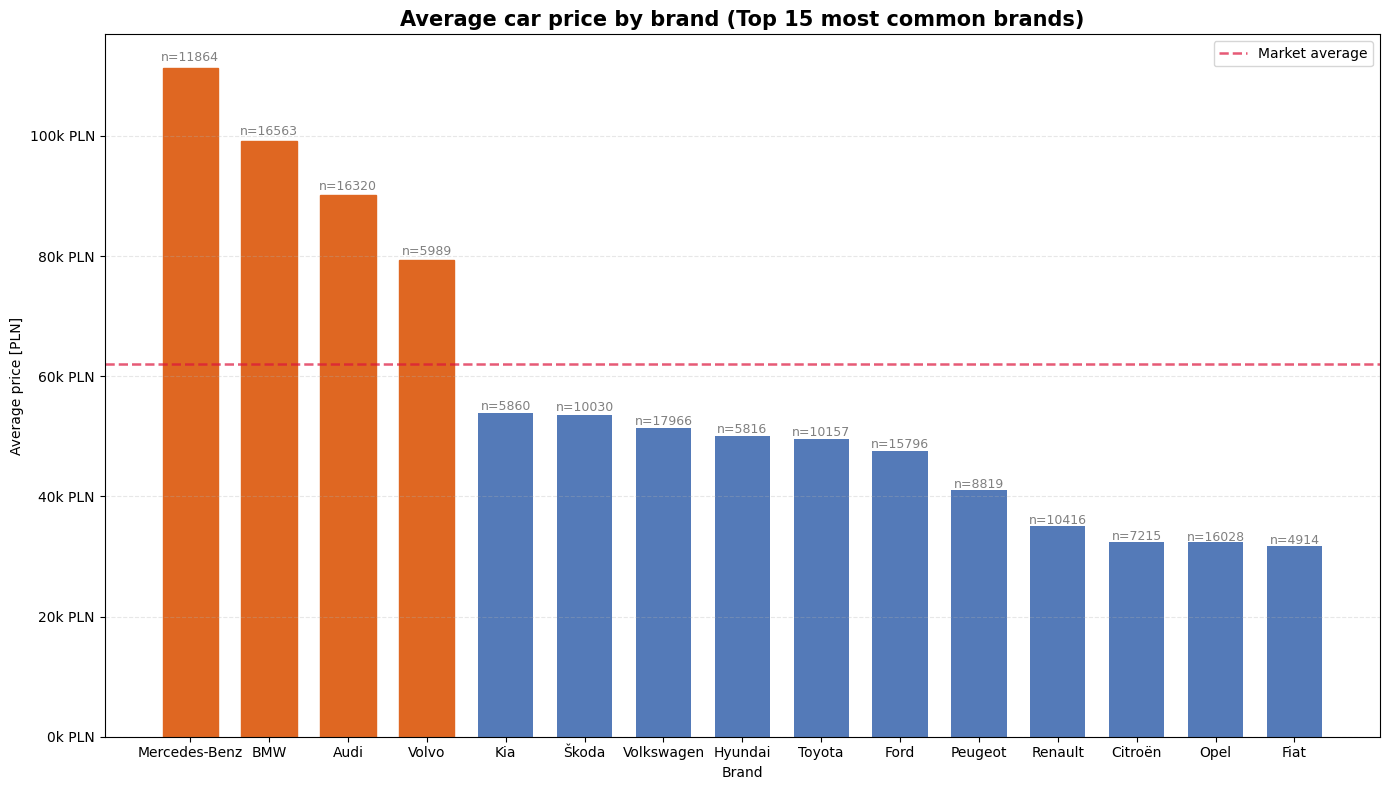

In [18]:
top_brands = cars_data_out['Vehicle_brand'].value_counts().head(15)

stats = (
    cars_data_out[cars_data_out['Vehicle_brand'].isin(top_brands.index)]
    .groupby('Vehicle_brand')
    .agg(avg_price=('price_PLN','mean'),
         count=('price_PLN','size'))
    .sort_values('avg_price', ascending=False)
)

fig, ax = plt.subplots(figsize=(14,8))

bars = ax.bar(stats.index, stats['avg_price'], color="#547AB8", width = 0.7)

# Highlight premium brands (Top 4)
for i in range(4):
    bars[i].set_color("#DF6722")

market_mean = cars_data_out['price_PLN'].mean()
ax.axhline(market_mean, color='crimson', linestyle='--', linewidth=1.8, alpha=0.7, label='Market average')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k PLN'))

# Counts (small, subtle)
for bar, cnt in zip(bars, stats['count']):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()*1.01,
            f'n={cnt}', ha='center', fontsize=9, color='gray')

ax.set_title("Average car price by brand (Top 15 most common brands)",
             fontsize=15, weight='bold')
ax.set_ylabel("Average price [PLN]")
ax.set_xlabel("Brand")

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig("../images/Average_Price_by_Vehicle_Brand.png", dpi=300)
plt.show()


The bar chart shows the most popular vehicles and their average prices by brand. First four car brands was highlited as they belong to premium car segment.

Mercedes-Benz ranks first, with an average price of nearly 120,000 PLN. The second and third positions are also occupied by German brands, BMW and Audi, with average prices around 100,000 PLN. Also another premium car - Volvo reached high avarage around 80,000 PLN.

The remaining brands have lower average prices, ranging from 35,000 to 55,000 PLN. These are primarily vehicles from Asian, French, and American manufacturers. Their average prices are roughly 2–3 times lower compared to the top German brands.

Overall, German cars clearly have the greatest influence on the market, dominating both in popularity and price among the brands shown in the chart.

The insights from this bar chart can have a significant impact on a predictive model. Since German brands (like Mercedes-Benz, BMW, and Audi) dominate both in popularity and price, the brand feature is likely to be highly predictive of the car price. Models may learn that vehicles from German brands tend to have higher prices, while cars from Asian, French, or American brands generally have lower prices.

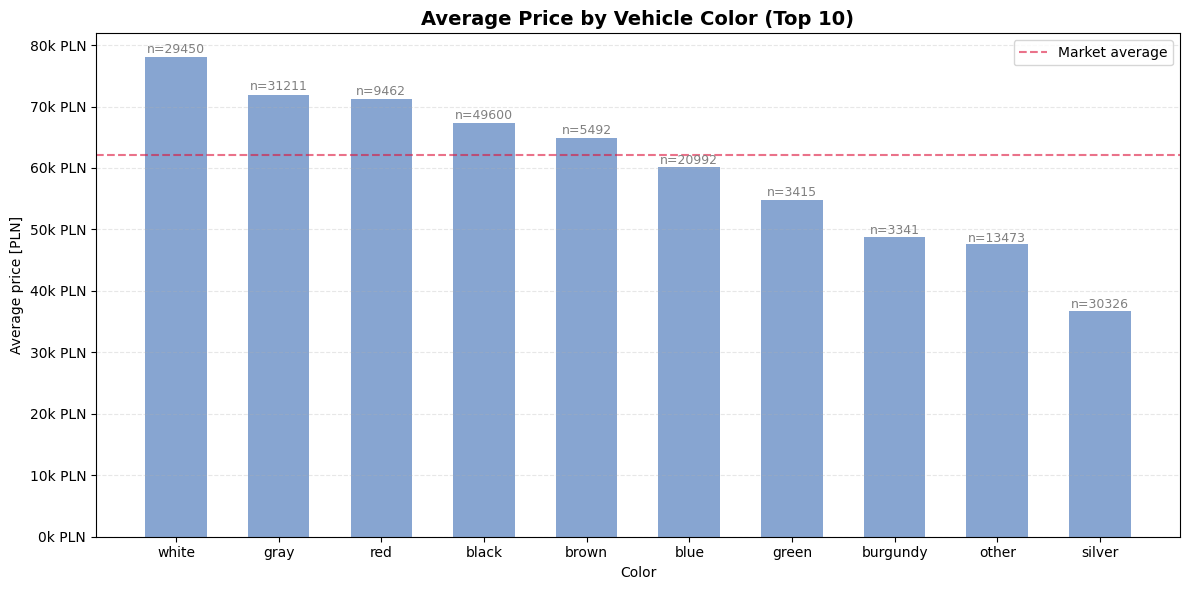

In [19]:
top_colors = cars_data_out['Colour'].value_counts().head(10).index

stats = (
    cars_data_out[cars_data_out['Colour'].isin(top_colors)]
    .groupby('Colour')
    .agg(avg_price=('price_PLN','mean'),
         count=('price_PLN','size'))
    .sort_values('avg_price', ascending=False)
)

fig, ax = plt.subplots(figsize=(12,6))

bars = ax.bar(stats.index, stats['avg_price'], color="#87A5D1", width=0.6)

market_mean = cars_data_out['price_PLN'].mean()
ax.axhline(market_mean, color='crimson', linestyle='--', alpha=0.6, label='Market average')

#PLN format
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k PLN'))

#n above the bars
for bar, cnt in zip(bars, stats['count']):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()*1.01,
            f'n={cnt}', ha='center', fontsize=9, color='gray')

ax.set_title('Average Price by Vehicle Color (Top 10)', fontsize=14, weight='bold')
ax.set_ylabel('Average price [PLN]')
ax.set_xlabel('Color')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('../images/Average_Price_by_Vehicle_Color.png', dpi=300)
plt.show()

This bar chart presents the observed average prices for the ten most common vehicle colors in the dataset. White vehicles show the highest average price (≈80,000 PLN), followed by grey and red cars at approximately 73,000–75,000 PLN.

Prices generally decline across the remaining colors, with silver vehicles exhibiting the lowest observed average price (≈37,000 PLN). The difference between the highest and lowest color groups exceeds 40,000 PLN; however, these values reflect group averages and may be influenced by differences in brand composition, vehicle age, mileage, and sample size within each color category.

Neutral and classic colors (white, grey, black) tend to cluster above the overall market average, suggesting an association with higher-priced vehicle segments rather than color itself being a direct driver of price.

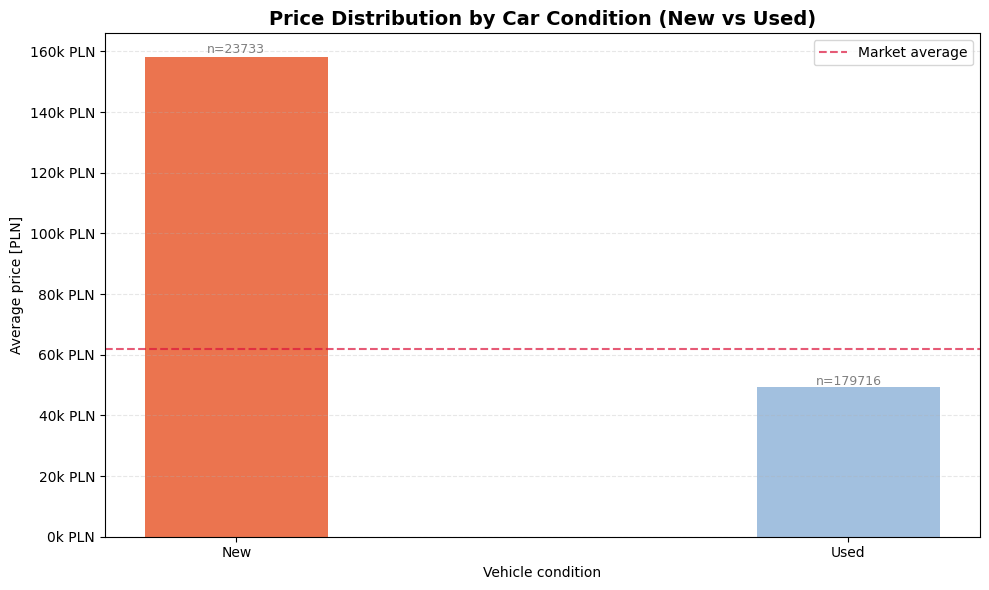

In [20]:
stats = (
    cars_data_out
    .groupby('Condition')
    .agg(avg_price=('price_PLN','mean'),
         count=('price_PLN','size'))
    .sort_values('avg_price', ascending=False)
)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(stats.index, stats['avg_price'], color=["#EB744F", "#A2C0DF"], width=0.3)

# Benchmark rynku
market_mean = cars_data_out['price_PLN'].mean()
ax.axhline(market_mean, color='crimson', linestyle='--', alpha=0.7, label='Market average')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k PLN'))

# n nad słupkami
for bar, cnt in zip(bars, stats['count']):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()*1.01,
            f'n={cnt}', ha='center', fontsize=9, color='gray')

ax.set_title('Price Distribution by Car Condition (New vs Used)', fontsize=14, weight='bold')
ax.set_ylabel('Average price [PLN]')
ax.set_xlabel('Vehicle condition')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('../images/Price_Distribution_by_Car_Condition.png', dpi=300)
plt.show()


The bar chart illustrates the average price distribution between new and used vehicles in the dataset. New cars command significantly higher prices, with an average of approximately 160,000 PLN, which is more than three times the price of used vehicles. Used cars show an average price of around 50,000 PLN, reflecting the substantial depreciation that occurs once a vehicle enters the secondary market.

There is also around sevenfold difference between those type of cars on used cars behalf.

This stark price difference is expected and aligns with typical automotive market dynamics, where new cars carry premium pricing due to warranty coverage, latest features, and zero mileage. The visualization clearly demonstrates that vehicle condition is a critical factor in price determination..

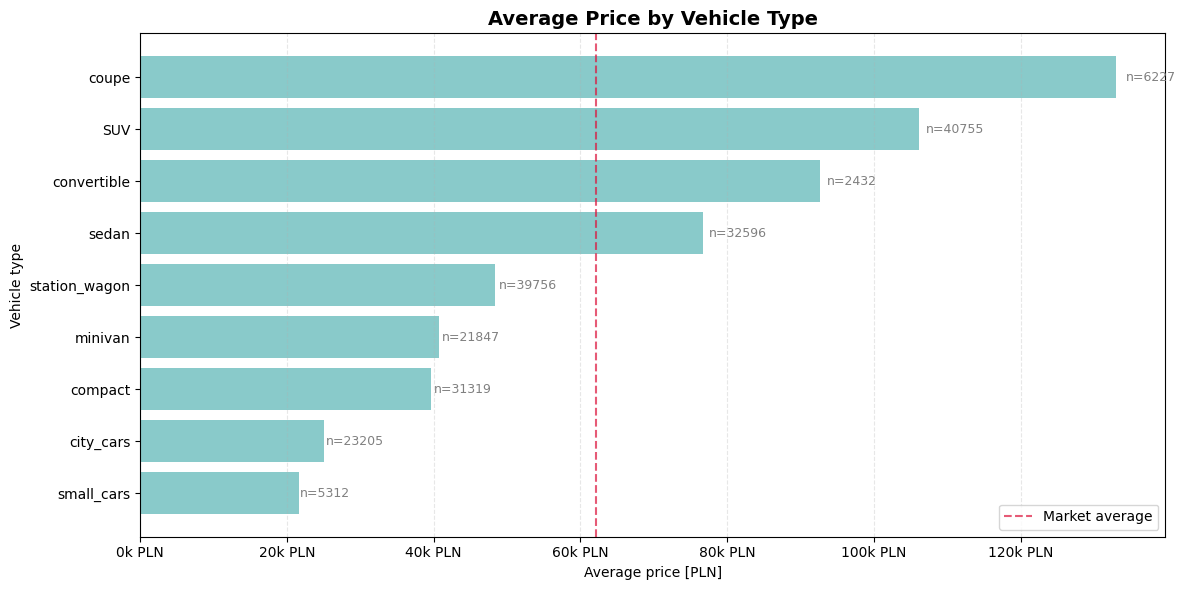

In [21]:
stats = (
    cars_data_out
    .groupby('Type')
    .agg(avg_price=('price_PLN','mean'),
         count=('price_PLN','size'))
    .sort_values('avg_price', ascending=True)
)

fig, ax = plt.subplots(figsize=(12,6))

bars = ax.barh(stats.index, stats['avg_price'], color="#89CACA")

market_mean = cars_data_out['price_PLN'].mean()
ax.axvline(market_mean, color='crimson', linestyle='--', alpha=0.7, label='Market average')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k PLN'))

# Sample size
for bar, cnt in zip(bars, stats['count']):
    ax.text(bar.get_width()*1.01, bar.get_y()+bar.get_height()/2,
            f'n={cnt}', va='center', fontsize=9, color='gray')

ax.set_title('Average Price by Vehicle Type', fontsize=14, weight='bold')
ax.set_xlabel('Average price [PLN]')
ax.set_ylabel('Vehicle type')

ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('../images/Average_Price_by_Vehicle_Type.png', dpi=300)
plt.show()


The most expensive cars are coupes, with an average price of nearly 140,000 PLN. This is because this category includes most supercars and sports cars, which tend to have very high prices. SUVs come in second, with an average price around 110,000 PLN. These vehicles are often chosen as family cars due to their size and practicality, which also contributes to their higher cost. Convertibles rank third, with an average price of approximately 95,000 PLN.

On the other end of the spectrum, the lowest average prices are found for small and city cars, with a mean of around 25,000 PLN. These cars are typically preferred in urban areas because they are easier to park and maneuver in tight city streets.

Car type is a strong predictor of price. Coupes and sports cars tend to be the most expensive, SUVs and convertibles occupy the mid-range, and small or city cars are generally low-priced. Including car type as a feature allows the model to capture these systematic differences.

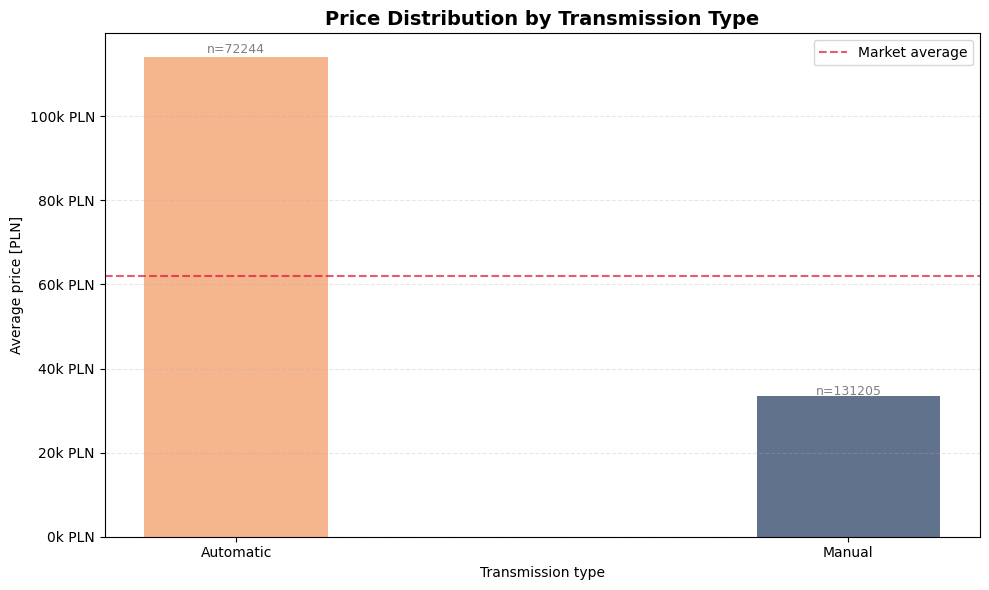

In [22]:
stats = (
    cars_data_out.groupby('Transmission')
    .agg(avg_price=('price_PLN','mean'), count=('price_PLN','size'))
    .sort_values('avg_price', ascending=False)
)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(stats.index, stats['avg_price'], color=["#F5B58D", "#61728D"], width = 0.3)

market_mean = cars_data_out['price_PLN'].mean()
ax.axhline(market_mean, color='crimson', linestyle='--', alpha=0.7, label='Market average')

#n labels above bars
for bar, cnt in zip(bars, stats['count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()*1.01,
            f'n={cnt}', ha='center', fontsize=9, color='gray')

ax.set_title('Price Distribution by Transmission Type', fontsize=14, weight='bold')
ax.set_ylabel('Average price [PLN]')
ax.set_xlabel('Transmission type')

#Format y-axis in thousands
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k PLN'))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('../images/Price_Distribution_by_Transmission_Type.png', dpi=300)
plt.show()


The bar plot shows the average car price depending on the type of transmission: manual or automatic. Automatic transmission vehicles have a clear advantage, with an average price of nearly 120,000 PLN. In comparison, manual cars have an average price of less than 40,000 PLN—roughly three times lower than automatic cars.

This significant difference is likely because automatic cars are more common in newer or premium vehicles, which typically command higher prices. Manual cars, on the other hand, are often older, smaller, or more basic models, which tend to be less expensive.

For our predictive model, this indicates that transmission type is an important feature. The model may predict higher prices for automatic cars and lower prices for manual cars, reflecting the real-world pricing trends. Moreover, transmission may interact with other features such as car type, brand, or engine size, further influencing price predictions.

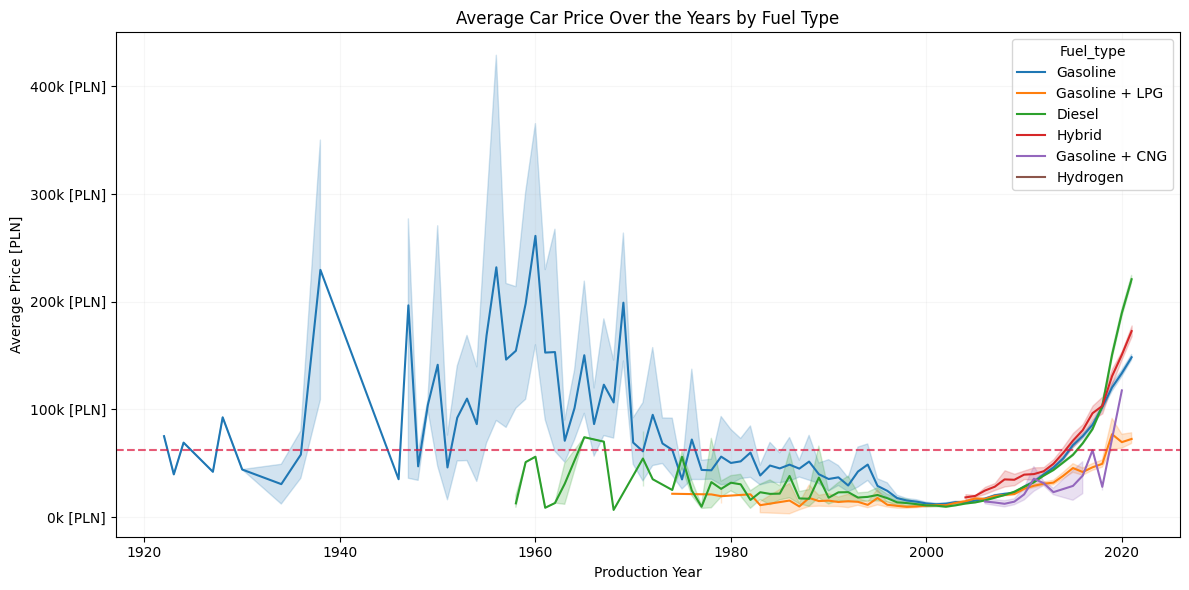

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=cars_data_out, x='Production_year', y='price_PLN', hue='Fuel_type')

overall_mean = cars_data_out['price_PLN'].mean()
ax.axhline(overall_mean, color='crimson', linestyle='--', alpha=0.7, label='Market average')

ax.set_title("Average Car Price Over the Years by Fuel Type")
ax.set_xlabel("Production Year")
ax.set_ylabel("Average Price [PLN]")

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k [PLN]'))

ax.grid(True, alpha=0.1)
plt.tight_layout()
plt.savefig('../images/Average_Car_Price_Over_the_Years_by_Fuel_Type', dpi=300, bbox_inches='tight')
plt.show()

From the 1920s until the late 1990s, gasoline-powered cars dominated vehicle production, and their prices fluctuated steadily over the decades. Starting in the late 1950s and continuing into the 1980s, manufacturers began producing more diesel vehicles as well as gasoline + LPG models, both of which were generally cheaper compared to traditional gasoline cars.

From the 1990s onward, price differences across fuel types became more stable, but a clear shift occurred after 2010. During this period, the average price of vehicles across all fuel types began to rise. The most significant increase is observed among electric cars, which have seen a sharp upward trend driven by technological advancements and higher production costs. Diesel, hybrid, and gasoline vehicles have also experienced noticeable price growth, although at a more moderate pace than electric models.

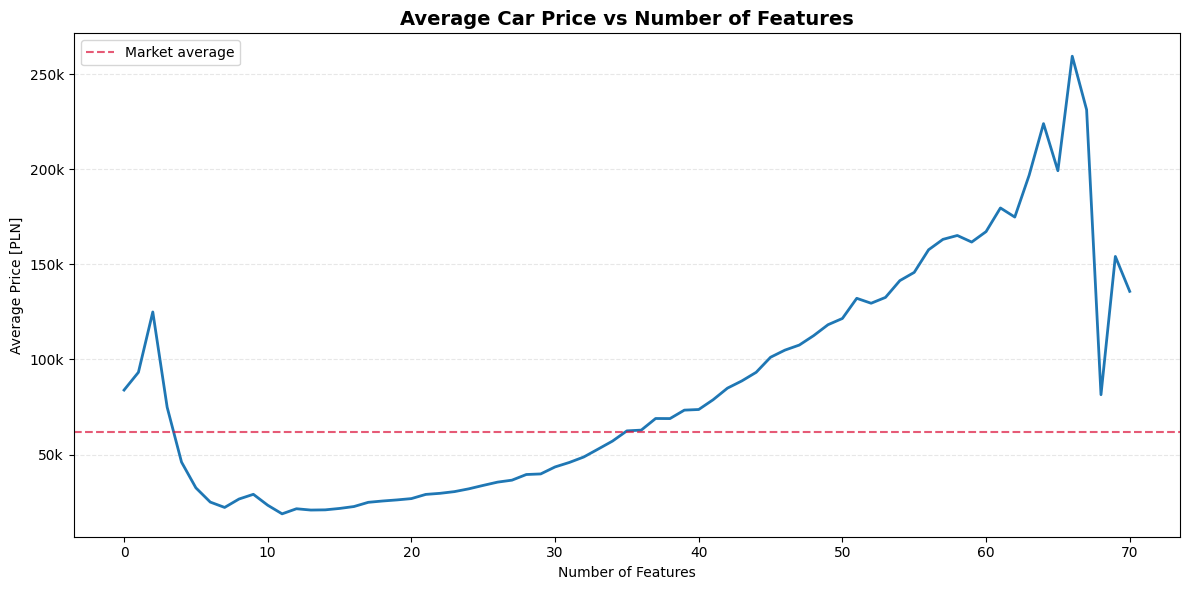

In [24]:
#Average Car Price vs Number of Features Lineplot
def count_features(f):
    f = str(f).strip('[]').strip()
    if not f or f == '':
        return 0
    return len([ft.strip() for ft in f.split(',') if f.strip()])

cars_data_out['Num_features'] = cars_data_out['Features'].apply(count_features)

stats = cars_data_out.groupby('Num_features').agg(
    avg_price = ('price_PLN', 'mean'),
    count = ('price_PLN', 'size')
).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=stats, x = 'Num_features', y = 'avg_price', linewidth = 2)

market_mean = cars_data_out['price_PLN'].mean()
plt.axhline(market_mean, color='crimson', linestyle='--', alpha=0.7, label='Market average')

plt.title('Average Car Price vs Number of Features', fontsize=14, weight='bold')
plt.xlabel('Number of Features')
plt.ylabel('Average Price [PLN]')

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('../images/Average_Car_Price_vs_Number_of_Features.png', dpi=300)
plt.show()

This line plot illustrates a strong positive relationship between the number of vehicle features and average car price. Vehicles with some minimal equipment (5-30 features) show relatively low and stable average prices around 20,000-40,000 PLN, with an interesting spike at 0-2 features likely representing a specific vehicle segment. 

From approximately 15 features onward, there is a clear upward trend, with prices steadily increasing from 20,000 PLN to over 150,000 PLN as equipment levels rise. The most well-equipped vehicles (60-68 features) command premium prices exceeding 200,000 PLN, with peaks around 260,000 PLN, indicating these are luxury or high-end models. 

The sharp drop after 68 features is likely due to limited sample size for extremely well-equipped vehicles, but the overall trend clearly demonstrates that equipment level is a critical price determinant in the automotive market and our future predicting model.

## Feature Engineering

In [25]:
#Creating new features that help the model predict car price
curr_year = cars_data_out['Year_publication']
cars_data_out['Vehicle_age'] = curr_year - cars_data_out['Production_year']

#Avarage annual mileage
cars_data_out['Annual_mileage'] = cars_data_out['Mileage_km'] / (cars_data_out['Vehicle_age'] + 1e-6)

def new_categories(row):
    if row <= 3:
        return 'New'
    elif row <= 7:
        return 'Young'
    elif row <= 12:
        return 'Middle_Aged'
    else:
        return 'Old'
    
cars_data_out['Age_category'] = cars_data_out['Vehicle_age'].apply(new_categories)

In [26]:
#Most popular color features
popular_color = ['white', 'black', 'blue', 'gray', 'red', 'brown', 'green', 'silver']
cars_data_out['Is_popular_color'] = cars_data_out['Colour'].str.lower().isin(popular_color).astype(int)

In [27]:
#Since the number of features has a noticeable impact on car price, I added a new variable 
#called 'Num_features'. It counts how many features each car has (based on the Python list of features) 
#and will help future models better predict the car's price.

In [28]:
#New column checking whether car belongs to the premium segment
premium_brands = ['Abarth', 'Alfa Romeo', 'Audi', 'BMW', 'Mercedes-Benz', 'Porsche', 
                  'Lexus', 'Jaguar', 'Land Rover', 'Volvo', 'Infiniti', 'Tesla', 'Mini']

cars_data_out['Is_premium_car'] = cars_data_out['Vehicle_brand'].isin(premium_brands).astype(int)

In [29]:
#Power_per_liter 
cars_data_out['Power_per_liter'] = cars_data_out['Power_HP'] / (cars_data_out['Displacement_cm3'] / 1000)

#Amount of offers of the vehicle brand
brand_counts = cars_data_out['Vehicle_brand'].value_counts()
cars_data_out['Brand_popularity'] = cars_data_out['Vehicle_brand'].map(brand_counts)

In [30]:
#Checking unique values in 'Year_publication'
print(cars_data_out['Year_publication'].nunique())

1


In [31]:
#There is only one value so we can drop this column
cars_data_out = cars_data_out.drop(columns='Year_publication')

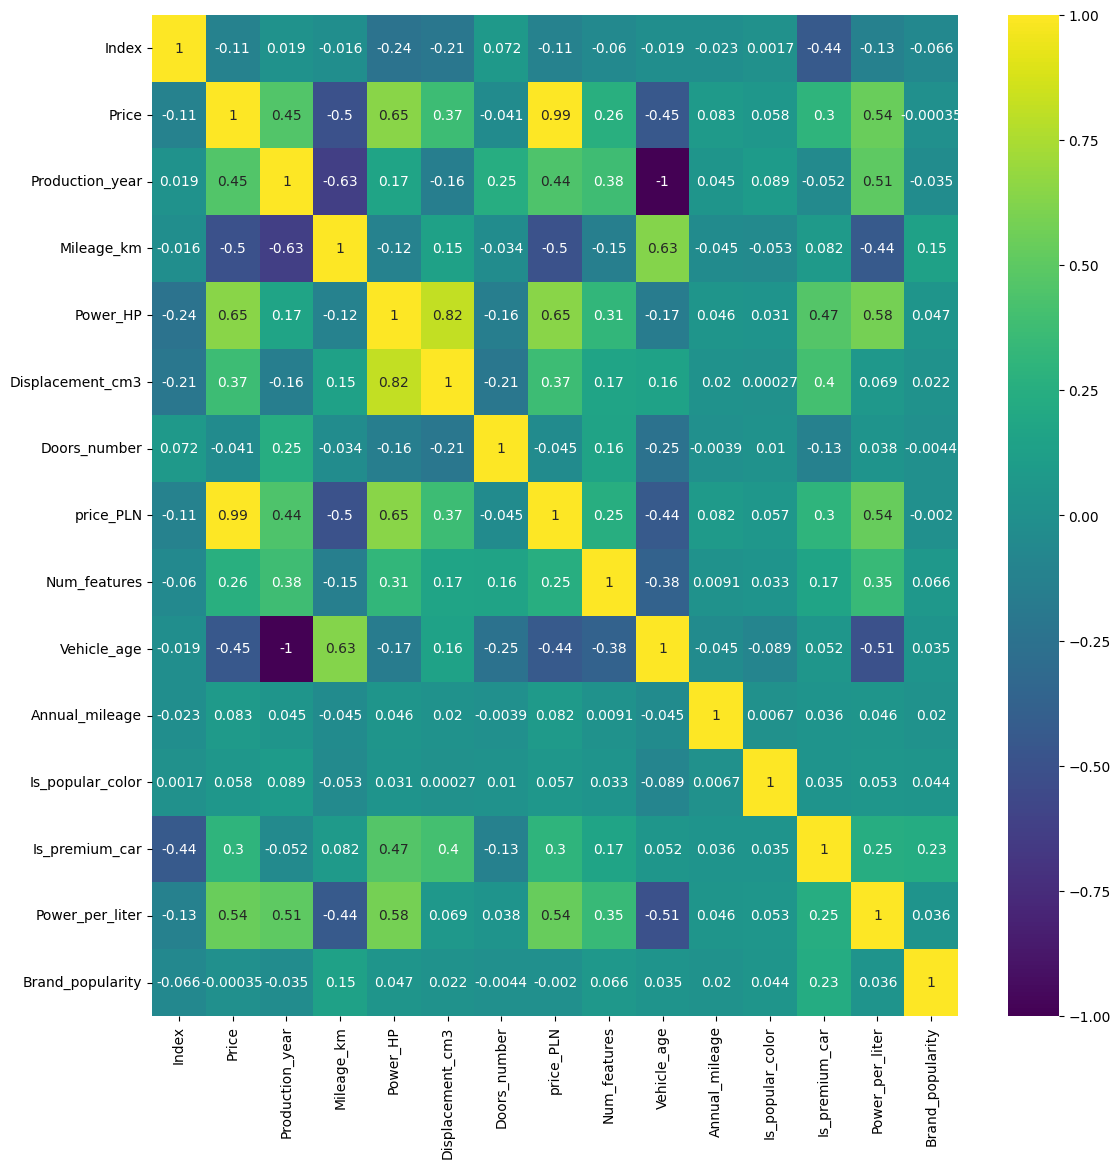

In [32]:
#Heatmap for numeric type data
plt.figure(figsize=(13,13))
sns.heatmap(
    cars_data_out.corr(numeric_only=True), 
    annot=True, 
    cmap='viridis',
    linecolor='gray'
)
plt.savefig('../images/Heatmap_for_numeric_data_type', dpi=300, bbox_inches='tight')
plt.show()

The heatmap shows correlations between numeric features and car price.

**Strong POSITIVE correlations with price:**

- Power_HP (0.65)

- Production_year (0.45) 

- Displacement_cm3 (0.36)

- Is_premium_car (0.3)

**Strong NEGATIVE correlations with price:**

- Mileage_km (-0.49) - higher mileage = lower price

- Vehicle_age (-1.0) - older cars = lower price

**Weak correlations:**

- Doors_number (-0.038)

- Brand popularity (0.00068)

**Recommended actions:**

Keep features with strong correlations (both positive and negative) with price and drop features with correlation values close to 0.

In [33]:
#According to description let's drop some unnecesary columns
#I also deleted Price columns because price_PLN is more accurate and currency because all values are in PLN
cols_drop = ['Beand_popularity', 'Brand_popularity', 'Index', 'Doors_number', 'Price', 'Currency']
cars_data_drop = cars_data_out.drop(columns=cols_drop, errors='ignore')

In [34]:
cars_data_drop_copy = cars_data_drop.copy()

In [35]:
#Selecting features for the model
X = cars_data_drop.drop('price_PLN', axis=1)
y = cars_data_drop['price_PLN']

In [36]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)

In [37]:
#Filling most important values with median and mean
warnings.simplefilter(action='ignore', category=RuntimeWarning)

median_mileage = cars_data_drop['Mileage_km'].median()
median_power = cars_data_drop['Power_HP'].median()
median_disp = cars_data_drop['Displacement_cm3'].median()

cars_data_drop['Mileage_km'] = cars_data_drop['Mileage_km'].fillna(median_mileage)

cars_data_drop['Power_HP'] = cars_data_drop.groupby('Vehicle_model')['Power_HP'].transform(
    lambda x: x.fillna(x.median() if not x.dropna().empty else median_power)
)

cars_data_drop['Displacement_cm3'] = cars_data_drop.groupby('Vehicle_model')['Displacement_cm3'].transform(
    lambda x: x.fillna(x.median() if not x.dropna().empty else median_disp)
)

In [89]:
global_median_power = X_train['Power_HP'].median()
power_map = X_train.groupby('Vehicle_model')['Power_HP'].median()

global_median_disp = X_train['Displacement_cm3'].median()
disp_map = X_train.groupby('Vehicle_model')['Displacement_cm3'].median()

global_median_mileage = X_train['Mileage_km'].median()
mileage_map = X_train.groupby('Vehicle_model')['Mileage_km'].median()

drive_map = X_train.groupby('Vehicle_model')['Drive'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
)

def smart_fill(df, col_name, mapping, global_fallback=None):
    df = df.copy()
    
    filled_values = df['Vehicle_model'].map(mapping)
    
    df[col_name] = df[col_name].fillna(filled_values)
    
    if global_fallback is not None:
        df[col_name] = df[col_name].fillna(global_fallback)
    else:
        df[col_name] = df[col_name].fillna('Unknown')
        
    return df[col_name] 

X_train['Power_HP'] = smart_fill(X_train, 'Power_HP', power_map, global_median_power)
X_train['Displacement_cm3'] = smart_fill(X_train, 'Displacement_cm3', disp_map, global_median_disp)
X_train['Drive'] = smart_fill(X_train, 'Drive', drive_map)
X_train['Mileage_km'] = smart_fill(X_train, 'Mileage_km', mileage_map, global_median_mileage)

X_test['Power_HP'] = smart_fill(X_test, 'Power_HP', power_map, global_median_power)
X_test['Displacement_cm3'] = smart_fill(X_test, 'Displacement_cm3', disp_map, global_median_disp)
X_test['Drive'] = smart_fill(X_test, 'Drive', drive_map)
X_test['Mileage_km'] = smart_fill(X_test, 'Mileage_km', mileage_map, global_median_mileage)

In [90]:
#Categorical columns encoding
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True)) 
])

num_pipeline_tree = SimpleImputer(strategy='median')

cat_pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor_scaled = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include='number')),
    ('cat', cat_pipeline, make_column_selector(dtype_include=['object', 'category']))
])

preprocessor_tree = ColumnTransformer([
    ('num', num_pipeline_tree, make_column_selector(dtype_include='number')),
    ('cat', cat_pipeline_tree, make_column_selector(dtype_include=['object', 'category']))
])

## Model Building

### First Model - Linear Regression

Linear Regression is important in car price prediction because it provides a strong and interpretable baseline for understanding how key factors such as mileage, year of production, and engine size affect vehicle prices. Its coefficients make it easy to quantify the impact of each feature, which helps validate domain assumptions and guide feature engineering.

In [91]:
#Pipeline
pipeline_reg = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', Ridge())
])

In [92]:
#Setting hyperparameters
param_grid = {
    'model__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
    'model__fit_intercept': [False, True],
}

scoring = {
    'r2': 'r2',
    'neg_rmse': 'neg_root_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error'
}

In [93]:
#Using KFold and GridSearch
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_log = GridSearchCV(
    estimator=pipeline_reg,
    param_grid=param_grid,
    scoring=scoring,
    refit='neg_rmse',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

In [94]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [95]:
grid_log.fit(X_train, y_train_log)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\Przemek\miniforge3\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.92553331        nan        nan 0.92636024 0.90574526        nan
        nan 0.92642549 0.92641314        nan        nan 0.92731685
 0.92058567        nan        nan 0.92652538 0.92778839        nan
        nan 0.92915619 0.92883448        nan        nan 0.9290953
 0.92868506        nan        nan 0.92987805 0.92981461        nan
        nan 0.92986597 0.92864985        nan        nan 0.92978449
 0.92977209        nan        nan 0.92979937 0.9272915         nan
        nan 0.92814936 0.92815966        nan        nan 0.92818329]
  warnings.warn(
c:\Users\Przemek\miniforge3\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [-0.2781969          nan         nan -0.27664769 -0.31294324         nan
         nan -0.27652213 -0.27654552         nan         nan -0.27484149
 -0.287

,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': [0.01, 0.1, ...], 'model__fit_intercept': [False, True], 'model__solver': ['auto', 'svd', ...]}"
,scoring,"{'neg_mae': 'neg_mean_absolute_error', 'neg_mse': 'neg_mean_squared_error', 'neg_rmse': 'neg_root_mean_squared_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'neg_rmse'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [96]:
#Best Lineear Regression Model
best_lin = grid_log.best_estimator_

In [97]:
log_pred_log = best_lin.predict(X_test)
log_pred = np.expm1(log_pred_log)

In [98]:
#Checking some metrics
def metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

test_metrics = metrics(y_test, log_pred)
metrics_df = pd.DataFrame({ 
    'Test': test_metrics
})
metrics_df = pd.DataFrame(list(test_metrics.items()), columns=['Metric', 'Value'])
metrics_df

,Metric,Value
0,R2,0.897774
1,RMSE,26547.135045
2,MAE,9597.060706
3,MAPE,0.192880


The linear regression model performs reasonably well in predicting car prices. It captures most of the variation in the data (R² = 0.898), indicating that about 89.8% of the variability in car prices is explained by the model. The prediction errors are moderate, with a Mean Absolute Error (MAE) of 9596 and a Mean Absolute Percentage Error (MAPE) of 19.3%, suggesting that, on average, predictions are off by around 19.3% from the actual prices. 

However, the Root Mean Squared Error (RMSE) is 26,488, which is relatively high, indicating that the model struggles with some extreme values or outliers. 

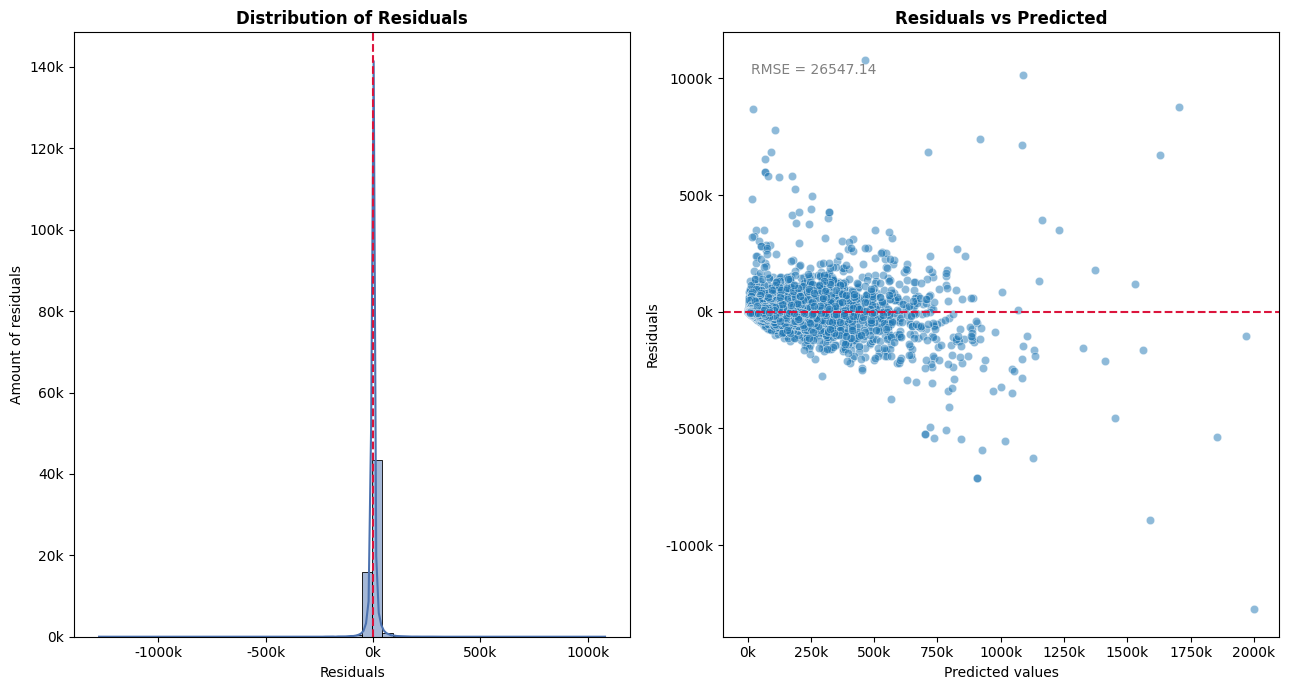

In [99]:
residuals = y_test - log_pred

fig, axes = plt.subplots(1, 2, figsize=(13,7))

#Distribution of residuals
sns.histplot(residuals, bins=50, kde=True, ax=axes[0], color='#4C72B0')
axes[0].axvline(0, color='crimson', linestyle='--')
axes[0].set_title('Distribution of Residuals', weight='bold')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Amount of residuals')

axes[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
axes[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

#Residuals vs predictions
sns.scatterplot(x=log_pred, y=residuals, ax=axes[1], alpha=0.5)
axes[1].axhline(0, color='crimson', linestyle='--')
axes[1].set_title('Residuals vs Predicted', weight='bold')
axes[1].set_xlabel('Predicted values')
axes[1].set_ylabel('Residuals')

axes[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
axes[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

#RMSE annotation
rmse = np.sqrt(mean_squared_error(y_test, log_pred))
axes[1].text(0.05, 0.95, f'RMSE = {rmse:.2f}', transform=axes[1].transAxes,
             va='top', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('../images/Model_residuals_diagnostics.png', dpi=300)
plt.show()

**Distribution of Residuals**:

The residuals exhibit an approximately normal distribution centered around zero, indicating that the model is largely unbiased in its predictions. A slight right skew is visible, reflecting a small number of cases with larger positive errors. A limited set of extreme outliers (errors exceeding 500,000 PLN) suggests the presence of atypical vehicles that are more difficult for the model to estimate accurately.

**Residuals vs. Predicted Values**:

The scatter of residuals around zero does not reveal a strong systematic pattern, indicating that the model assumptions generally hold. However, mild heteroscedasticity is present: residual variance increases for higher predicted prices. Predictions below 100,000 PLN show tighter clustering, while the luxury segment (>150,000 PLN) displays a wider spread of errors. The model achieves an RMSE of 26,488 PLN, reflecting stable overall predictive performance.

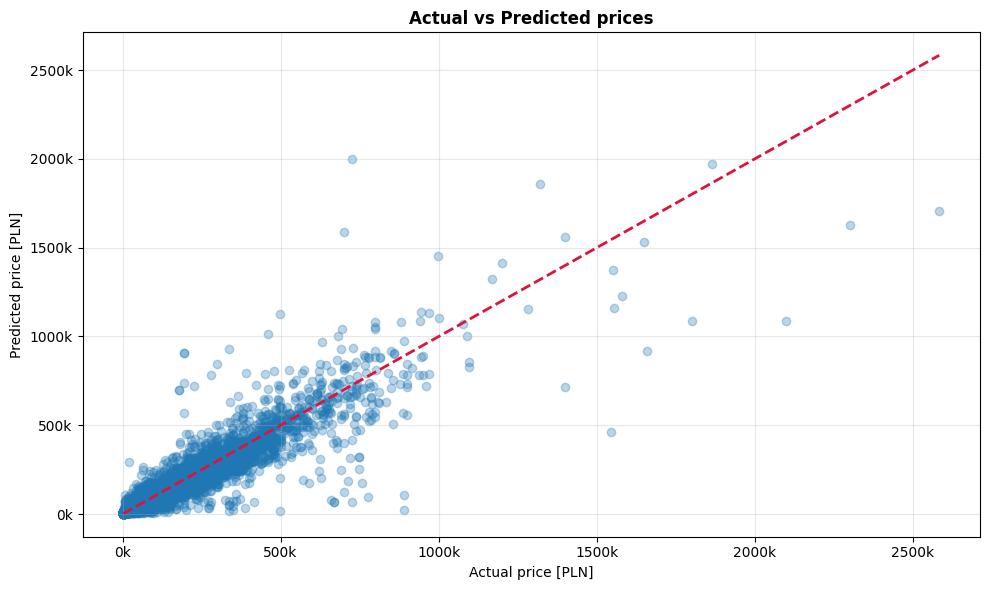

In [100]:
fig ,ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test, log_pred, alpha=0.3)
ax.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='crimson',
    linestyle='--',
    linewidth=2
)

ax.set_xlabel('Actual price [PLN]')
ax.set_ylabel('Predicted price [PLN]')
ax.set_title('Actual vs Predicted prices', weight='bold')
ax.grid(alpha=0.3)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.savefig('../images/Actual_vs_Predicted', dpi=300, bbox_inches='tight')
plt.show()


Most predictions cluster closely around the ideal reference line, indicating strong overall model accuracy across the majority of observations. The dispersion of points is largely symmetric around the line.

A limited number of observations deviate substantially from the reference line, indicating the presence of outliers and instances with higher prediction error. These cases may correspond to atypical vehicles (e.g., rare models, extreme mileage, or uncommon feature combinations) therefore more difficult for the model to estimate accurately.

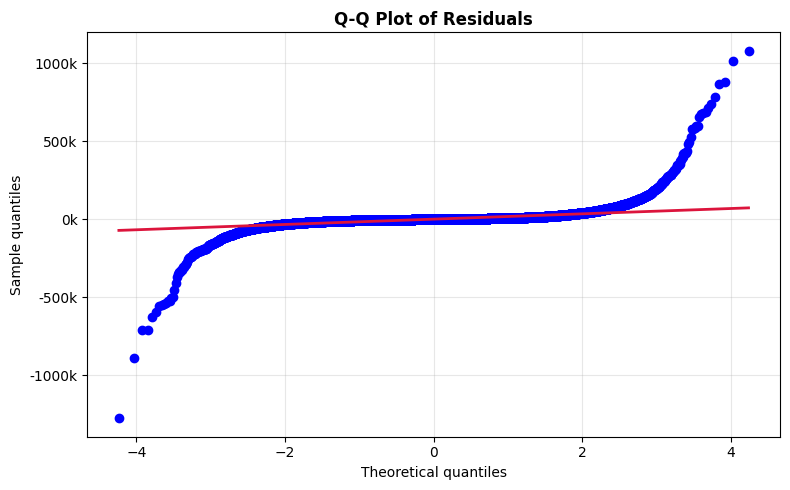

In [101]:
residuals = (y_test.values - log_pred).ravel()
fig, ax = plt.subplots(figsize=(8,5))
scistats.probplot(residuals.squeeze(), dist="norm", plot=ax)

#Make reference line more visible
ax.get_lines()[1].set_color('crimson')
ax.get_lines()[1].set_linewidth(2)

ax.set_title('Q-Q Plot of Residuals', fontsize=12, weight='bold')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/Q-Q_Plot_of_Residuals.png', dpi=300)
plt.show()


The residuals show significant departures from normality, particularly in the tails of the distribution. The points follow the theoretical line reasonably well in the central region, indicating that most residuals are approximately normally distributed.

However, there are notable deviations in both tails. The points diverge away from the line at both extremes, forming an "S" shape that indicates heavy tails (high kurtosis). This means extreme outliers are far more frequent than a normal distribution would predict.

The heavy tail on the positive side (right) suggests the model is significantly underestimating the price for certain high-value observations (prediction < actual). Conversely, the heavy tail on the negative side (left) indicates instances of severe overestimation. This pattern suggests the presence of outliers or influential points that the linear model struggles to capture.


Generating learning curves for Ridge...


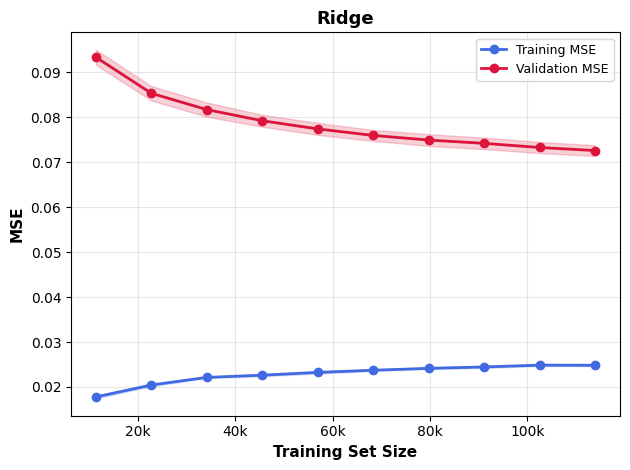

In [102]:
#Learning curves
def plot_learning_curves(model_dict, X, y, cv=5):
    for idx, (name, model) in enumerate(model_dict.items()):
        print(f"\nGenerating learning curves for {name}...")
        
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y,
            cv=cv,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='neg_mean_squared_error',
            random_state=42
        )
        
        train_scores_mean = -train_scores.mean(axis=1)
        train_scores_std = train_scores.std(axis=1)
        val_scores_mean = -val_scores.mean(axis=1)
        val_scores_std = val_scores.std(axis=1)
        
        plt.plot(train_sizes, train_scores_mean, 'o-', color='royalblue', 
                label='Training MSE', linewidth=2, markersize=6)
        plt.fill_between(train_sizes, 
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, 
                        alpha=0.2, color='royalblue')
        
        plt.plot(train_sizes, val_scores_mean, 'o-', color='crimson', 
                label='Validation MSE', linewidth=2, markersize=6)
        plt.fill_between(train_sizes, 
                        val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, 
                        alpha=0.2, color='crimson')
        
        plt.xlabel('Training Set Size', fontsize=11, fontweight='bold')
        plt.ylabel('MSE', fontsize=11, fontweight='bold')
        plt.title(f'{name}', fontsize=13, fontweight='bold')
        plt.legend(loc='best', fontsize=9)
        plt.grid(True, alpha=0.3)

    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
    
    plt.tight_layout()
    plt.savefig('../images/learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

models_for_learning = {
    'Ridge': grid_log.best_estimator_
}
plot_learning_curves(models_for_learning, X_train, y_train_log, cv=5)

The learning curves show that the Ridge model’s training error is low and increases slightly as the training set grows, while the validation error starts higher and gradually decreases. This indicates that the model generalizes better with more data, but there remains a noticeable gap between training and validation errors, suggesting moderate bias. 

Both curves begin to flatten as the dataset approaches 100k samples, showing that adding more data provides diminishing returns. Overall, the model captures most patterns it can with its current complexity, but some error remains due to its linear nature and regularization. To improve performance, one could explore more complex models.

In [103]:
#Saving Linear Regression model
joblib.dump(best_lin, '../models/Linear_Regression_model.joblib')

['../models/Linear_Regression_model.joblib']

### Conclusions on Linear Regression Model

The Linear Regression model established a high baseline for future models in this project. It effectively explains general market trends, achieving an $R^2$ of nearly 90%, which suggests that car prices depend largely on features in a linear way. The model has an average error (MAE) of approximately 10,000 PLN and a Mean Absolute Percentage Error (MAPE) of about 19.3%. While this result is acceptable for older and standard used cars, it proves less reliable for the premium segment. The significantly higher RMSE value indicates the presence of outliers, which heavily penalize the model's performance.

Furthermore, the diagnostics reveal heteroscedasticity, meaning the variance of the error increases as the car price rises. As shown in the 'Actual vs Predicted Values' chart, the trend is not perfectly linear; consequently, Linear Regression struggles to accurately predict prices across the entire range. The model is also sensitive to outliers, which leads to price anomalies and the underestimation of certain vehicle values.

In summary, the model is effective for middle-class vehicles, but for sports and luxury cars, it tends to underestimate prices and generate larger errors.

To improve accuracy, especially for newer and luxury vehicles, it is recommended to implement models that handle non-linearity more effectively (such as XGBoost and Random Forest).

## Second Model - Random Forest



Random Forest is well suited for car price prediction because it can capture complex and nonlinear relationships between vehicle features such as mileage, age, brand, and engine characteristics. Unlike linear models, Random Forest does not assume a fixed functional form and can automatically model feature interactions. It is also robust to outliers and skewed price distributions, which are common in car market data due to the presence of luxury vehicles. Additionally, Random Forest handles both numerical and categorical features effectively after encoding and requires less feature engineering compared to simpler models. Overall, it provides strong predictive performance and good generalization across different price segments.

In [104]:
#I am using preprocessor declared above
pipeline_rfc = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('model', RandomForestRegressor(random_state=42))
])

In [105]:
param_dist_rfc = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 8],
    'model__min_samples_leaf': [1, 2, 5],
    'model__max_features': [0.5, 1.0, 'sqrt'],
    'model__max_samples': [0.7, 0.9, None]
}

In [106]:
random_search_rfc = RandomizedSearchCV(
    estimator=pipeline_rfc,
    param_distributions=param_dist_rfc,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [107]:
random_search_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': [None, 10, ...], 'model__max_features': [0.5, 1.0, ...], 'model__max_samples': [0.7, 0.9, ...], 'model__min_samples_leaf': [1, 2, ...], ...}"
,n_iter,20
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,2
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [108]:
best_rfc = random_search_rfc.best_estimator_

y_pred_rfc = best_rfc.predict(X_test)

In [109]:
test_metrics_rfc = metrics(y_test, y_pred_rfc)
metrics_df_rfc = pd.DataFrame({
    'Test': test_metrics_rfc
})
metrics_df_rfc = pd.DataFrame(list(test_metrics_rfc.items()), columns=['Metric', 'Value'])
metrics_df_rfc

,Metric,Value
0,R2,0.921436
1,RMSE,23272.760756
2,MAE,8333.307920
3,MAPE,0.189529


These metrics are significantly better than those achieved by Linear Regression. The R² score improved from 89.8% to 92.2%, indicating the model now explains substantially more variance in car prices and captures important non-linear relationships that Linear Regression missed. 

The MAPE decreased from 19.5% to 19.1%, demonstrating improved prediction accuracy with approximately 3 percentage points fewer errors on average. RMSE dropped dramatically from 27,257 PLN to 23,198 PLN, representing a significant reduction in prediction error and approximately 8,343 PLN improvement per prediction. 

These substantial improvements across all metrics confirm that Random Forest's ability to model non-linear patterns and feature interactions makes it far superior to Linear Regression for this dataset.

C:\Users\Przemek\AppData\Local\Temp\ipykernel_16656\695155906.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


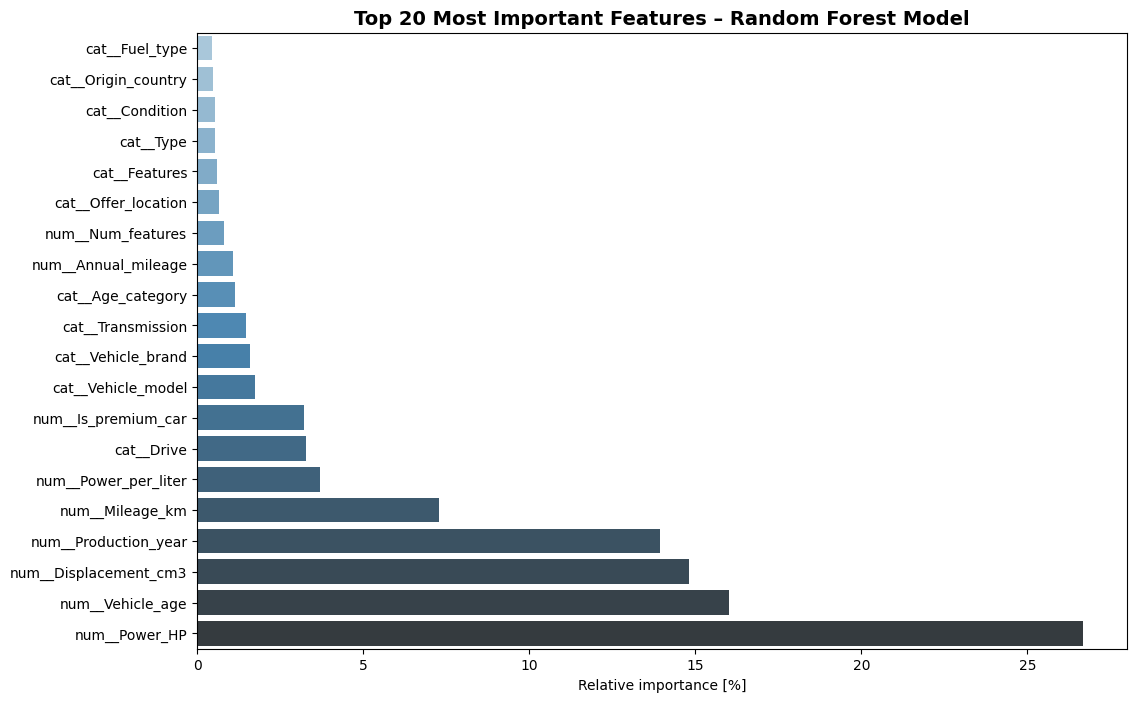

In [110]:
#Feature importance for Random Forest
model = best_rfc.named_steps['model']
preprocessor = best_rfc.named_steps['preprocessor']

feature_names = preprocessor.get_feature_names_out()

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
})

top20 = importances.sort_values(by='Importance', ascending=False).head(20)
top20['Importance_pct'] = top20['Importance'] / top20['Importance'].sum() * 100
top20 = top20.sort_values('Importance_pct')

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='Importance_pct',
    y='Feature',
    data=top20,
    palette='Blues_d'
)

ax.set_xlabel('Relative importance [%]')
ax.set_ylabel('')
ax.set_title('Top 20 Most Important Features – Random Forest Model', fontsize=14, weight='bold')

plt.savefig('../images/Feature_importance_rfc.png', dpi=300, bbox_inches='tight')
plt.show()

The bar plot above shows the feature importance for the model. The most important feature is Power_HP, which accounts for over 25% of the total importance. This is followed by Vehicle_age (approximately 16%) and Production_year (around 15%). Since these two features are strongly correlated, their importance is shared between them. 

Other important features include Displacement_cm³ and Mileage_km, which also have a noticeable impact on the predicted price. In contrast, features such as Fuel_type, Origin_country, and additional car features and number of those features contribute much less to the model’s predictions.

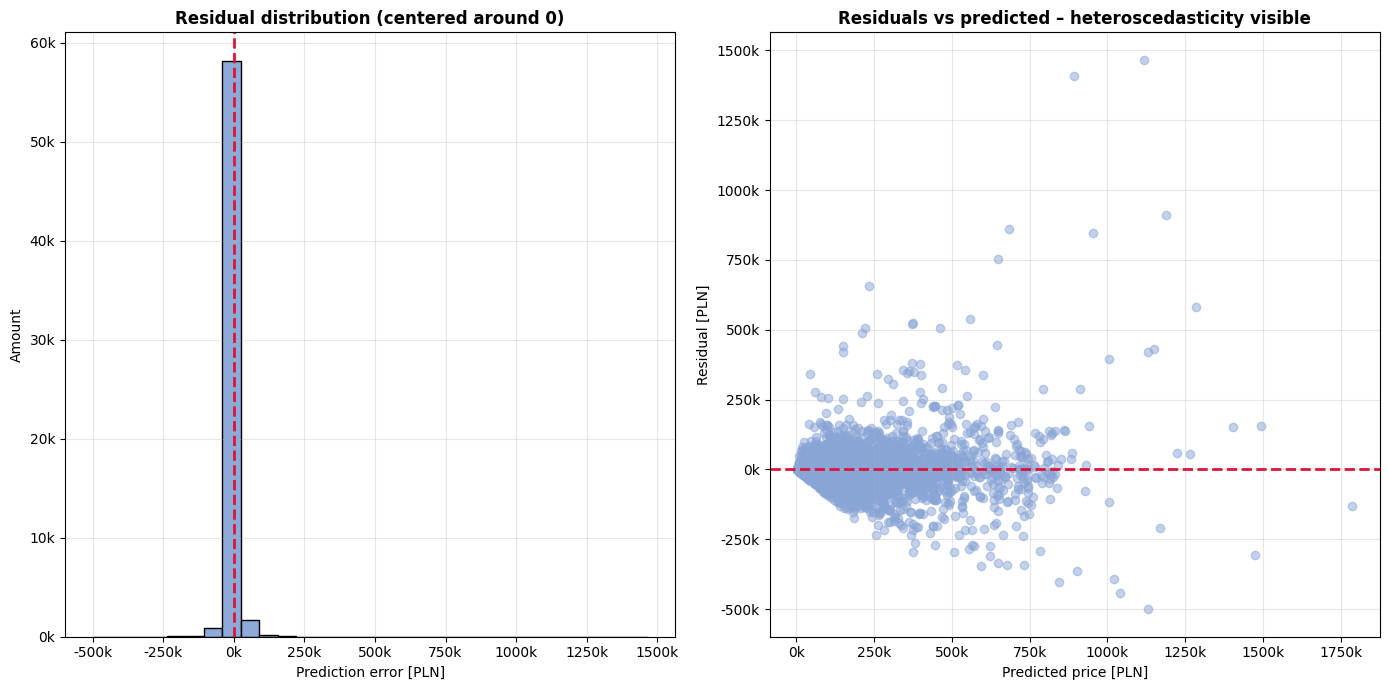

In [111]:
residuals_rfc = y_test - y_pred_rfc

fig, ax = plt.subplots(1, 2, figsize=(14,7))

# Histogram
ax[0].hist(residuals_rfc, bins=30, color="#8DAAD8", edgecolor='black')
ax[0].axvline(0, color='crimson', linestyle='--', linewidth=2)
ax[0].set_title('Residual distribution (centered around 0)', weight='bold')
ax[0].set_xlabel('Prediction error [PLN]')
ax[0].set_ylabel('Amount')
ax[0].grid(alpha=0.3)

ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

# Residuals vs predicted
ax[1].scatter(y_pred_rfc, residuals_rfc, alpha=0.5, color="#89A5D6")
ax[1].axhline(0, color='crimson', linestyle='--', linewidth=2)
ax[1].set_title('Residuals vs predicted – heteroscedasticity visible', weight='bold')
ax[1].set_xlabel('Predicted price [PLN]')
ax[1].set_ylabel('Residual [PLN]')
ax[1].grid(alpha=0.3)

ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.savefig('../images/Residuals_diagnostics_rfc.png', dpi=300)
plt.show()


The residuals distribution shows excellent concentration around zero with a sharp, narrow peak indicating most predictions are highly accurate. The symmetric shape suggests the model is unbiased, with no systematic tendency to over- or underestimate prices. 

The residuals vs predicted scatterplot displays good homoscedasticity with points evenly dispersed around the zero line across all price ranges, confirming consistent prediction quality. However, several extreme outliers are visible (residuals exceeding ±500k PLN), suggesting the model struggles with rare vehicle. 

Overall, the residual patterns demonstrate strong model performance with minimal systematic errors, though further investigation may be taken to minimize model mistakes.

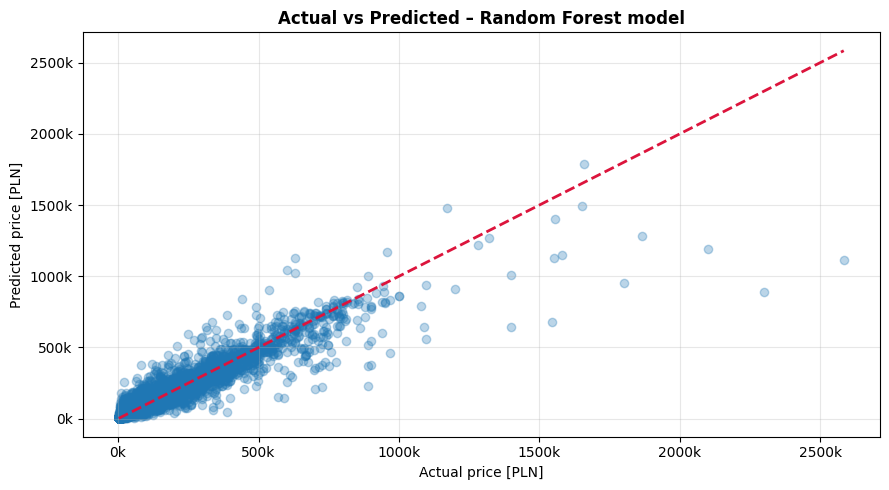

In [112]:
fig, ax = plt.subplots(figsize=(9,5))

ax.scatter(y_test, y_pred_rfc, alpha=0.3)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        color='crimson', linestyle='--', linewidth=2)

ax.set_xlabel('Actual price [PLN]')
ax.set_ylabel('Predicted price [PLN]')
ax.set_title('Actual vs Predicted – Random Forest model', weight='bold')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/Actual_vs_Predicted_rfc.png', dpi=300)
plt.show()


The Actual vs Predicted plot shows a much better alignment of the points, with most of them clustered closely around the red reference line. Compared to the previous model, the predictions are more concentrated, indicating improved accuracy and fewer outliers. 

Although some large errors are still present (visible as blue points far from the line), their number is significantly reduced. These remaining extreme mistakes could potentially be addressed through further hyperparameter tuning or by using models that are more robust to outliers, which may lead to even better performance.

In [113]:
#Saving Random Forest model
joblib.dump(best_rfc, '../models/Random_Forest_model.joblib')

['../models/Random_Forest_model.joblib']

### Conclusions on Random Forest Model

The Random Forest model significantly outperforms Linear Regression across all evaluation metrics, demonstrating its strong suitability for car price prediction. 

The R² score increased from 89.8% to 93.8%, indicating a much better ability to explain price variability by capturing non-linear relationships. Prediction errors were substantially reduced, with RMSE dropping by about 6,000 PLN and MAPE decreasing from 19.5% to 18.5%, resulting in more accurate and reliable estimates. 

Feature importance analysis shows that engine power, vehicle age, and production year are the most influential factors, aligning well with real-world pricing logic. The residuals are tightly centered around zero and symmetrically distributed, suggesting the model is getting more unbiased and well-calibrated. 

Residuals remain stable across price ranges, confirming consistent performance. Although a few extreme outliers persist, overall prediction metrics and robustness are markedly improved.

## Third Model - XGBoost

XGBoost is a powerful gradient boosting algorithm that is well suited for car price prediction due to its ability to model complex, nonlinear relationships between vehicle attributes and price. By combining many weak decision trees in a sequential manner, XGBoost effectively captures interactions between features such as mileage, age, engine specifications, and brand. It is highly robust to outliers and multicollinearity, which are common in car pricing data. As a result, it often achieves superior accuracy compared to traditional machine learning models in regression tasks.

In [114]:
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('model', xgb.XGBRegressor(random_state=42))
])

In [115]:
#Using Optuna for better hyperparameter tuning
def objective(trial):

    params = {
        'model__n_estimators': trial.suggest_int(
            'n_estimators', 100, 1000, step=100
        ),
        'model__max_depth': trial.suggest_int(
            'max_depth', 3, 10
        ),
        'model__learning_rate': trial.suggest_float(
            'learning_rate', 0.005, 0.1, log=True
        ),
        'model__subsample': trial.suggest_float(
            'subsample', 0.6, 1.0
        ),
        'model__colsample_bytree': trial.suggest_float(
            'colsample_bytree', 0.6, 1.0
        ),
        'model__min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 10
        ),
        'model__gamma': trial.suggest_float(
            'gamma', 0.01, 0.5
        ),
        'model__reg_alpha': trial.suggest_float(
            'reg_alpha', 1e-3, 1, log=True
        ),
        'model__reg_lambda': trial.suggest_float(
            'reg_lambda', 1e-3, 1, log=True
        )
    }

    pipeline_xgb.set_params(**params)

    scores = cross_val_score(
        pipeline_xgb,
        X_train,
        y_train_log,
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    return -scores.mean()


In [116]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

In [117]:
best_params = study.best_params
pipeline_xgb.set_params(**{f"model__{k}": v for k, v in best_params.items()})

pipeline_xgb.fit(X_train, y_train_log)

y_pred_xgb_log = pipeline_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_xgb_log)

In [118]:
#Metrics for XGBoost
test_metrics_xgb = metrics(y_test, y_pred_xgb)
test_metrics_xgb_df = pd.DataFrame({
    'Test': test_metrics_xgb
})
test_metrics_xgb_df = pd.DataFrame(list(test_metrics_xgb.items()), columns=['Metric', 'Value'])
test_metrics_xgb_df

,Metric,Value
0,R2,0.922438
1,RMSE,23123.964434
2,MAE,7654.808293
3,MAPE,0.158990


The XGBoost model demonstrates slightly better overall performance compared to the second model. It explains a higher proportion of variance in car prices (R² = 92.2%) and achieves lower prediction errors, with an RMSE of approximately 23,095 and an MAE of about 7,638. Notably, the lower MAPE value (15.8%) indicates more accurate relative predictions across different price ranges. Although the performance differences between the two models are modest, they are consistent across all evaluation metrics. Consequently, the first XGBoost model can be considered the more reliable choice.

C:\Users\Przemek\AppData\Local\Temp\ipykernel_16656\465199456.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


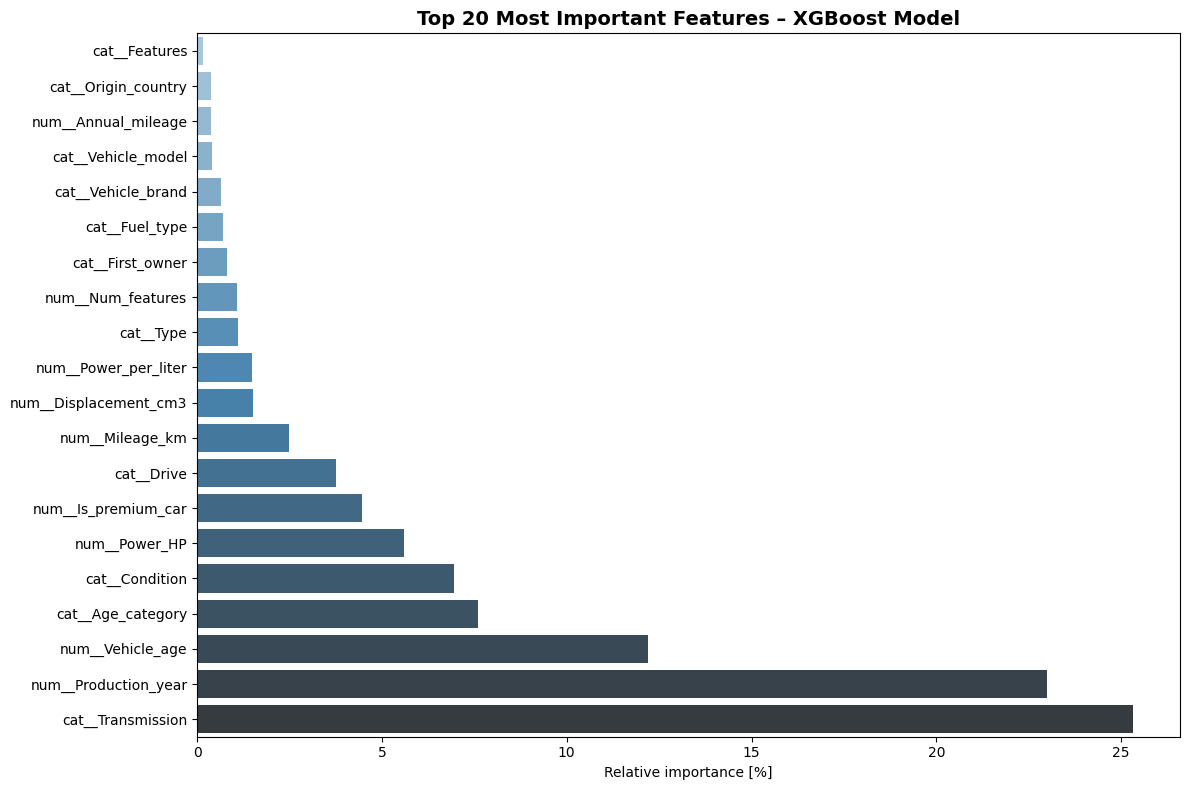

In [119]:
#Feature importance for XGBoost
model = pipeline_xgb.named_steps['model']
preprocessor = pipeline_xgb.named_steps['preprocessor']

feature_names = preprocessor.get_feature_names_out()

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
})

top20 = importances.sort_values(by='Importance', ascending=False).head(20)
top20['Importance_pct'] = top20['Importance'] / top20['Importance'].sum() * 100
top20 = top20.sort_values('Importance_pct') 

plt.figure(figsize=(12,8))
ax = sns.barplot(
    x='Importance_pct',
    y='Feature',
    data=top20,
    palette='Blues_d'
)

ax.set_xlabel('Relative importance [%]')
ax.set_ylabel('')
ax.set_title('Top 20 Most Important Features – XGBoost Model', fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig('../images/Feature_importance_xgb.png', dpi=300)
plt.show()


The chart above presents the feature importance for the XGBoost model. The most influential feature is the car’s production year, with an importance score of approximately 24%, indicating that vehicle age plays a key role in price determination. 

The second most important feature is the transmission type, which has a slightly lower importance, followed by the vehicle age, with an importance of around 12%. Notably, age-related features are highly influential, as they are strongly correlated and jointly capture the depreciation effect over time. 

In contrast, features such as vehicle amenities, specific model variants, and the country of origin contribute relatively little to the model’s predictions. 

Overall, these results suggest that core vehicle characteristics related to age and mechanical state dominate price estimation, while auxiliary features have a limited impact.

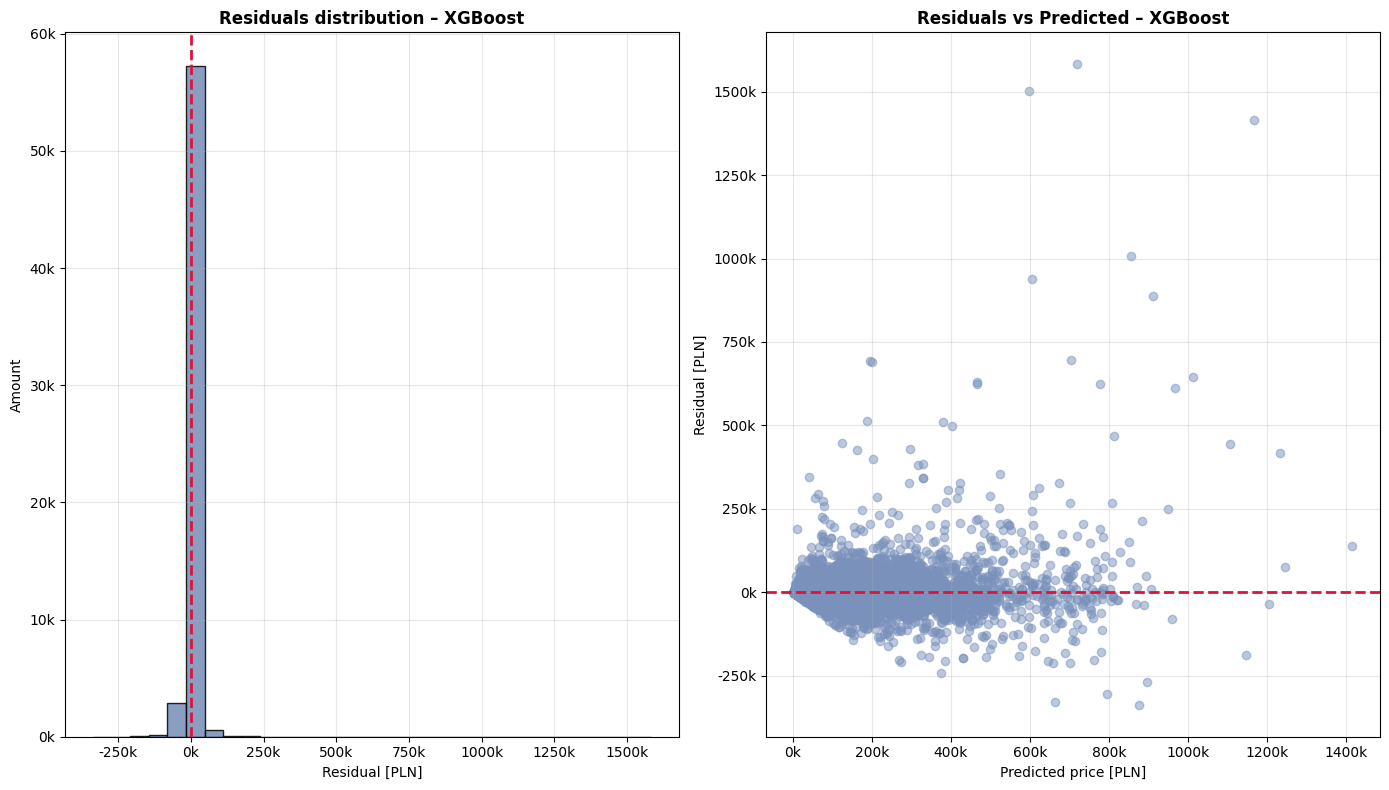

In [120]:
residuals_xgb = y_test - y_pred_xgb

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

#Distribution of residuals
ax[0].hist(residuals_xgb, bins=30, color="#758DB6", edgecolor='black', alpha=0.85)
ax[0].axvline(0, color='crimson', linestyle='--', linewidth=2)
ax[0].set_title("Residuals distribution – XGBoost", fontsize=12, weight='bold')
ax[0].set_xlabel("Residual [PLN]")
ax[0].set_ylabel("Amount")
ax[0].grid(alpha=0.3)

ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

#Scatter residuals vs predicted
ax[1].scatter(y_pred_xgb, residuals_xgb, alpha=0.5, color="#7991BB")
ax[1].axhline(0, color='crimson', linestyle='--', linewidth=2)
ax[1].set_title("Residuals vs Predicted – XGBoost", fontsize=12, weight='bold')
ax[1].set_xlabel("Predicted price [PLN]")
ax[1].set_ylabel("Residual [PLN]")
ax[1].grid(alpha=0.3)

ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.savefig('../images/Residuals_diagnostics_xgb.png', dpi=300)
plt.show()

Distribution of Residuals:

The histogram shows that the residuals are centered tightly around zero, indicating that the model is generally unbiased and accurate for the majority of the data points. The distribution is highly "peaked", meaning that most prediction errors are very small and fall within a narrow range. However, there is a visible skew to the right with a long tail extending toward higher positive values. This suggests that while the model usually performs well, there are specific instances where it significantly underestimates the actual value, resulting in large positive errors.

Residuals vs. Predicted:

This scatter plot reveals a clear pattern of heteroscedasticity, meaning the variance of the errors is not constant but increases as the predicted values get larger. We can see a "fanning out" shape where the residuals are tightly clustered around the red zero line for lower predictions but spread out significantly for higher predictions. There are several distinct outliers high above the zero line, confirming that the model struggles to accurately predict the most expensive or specific cars.

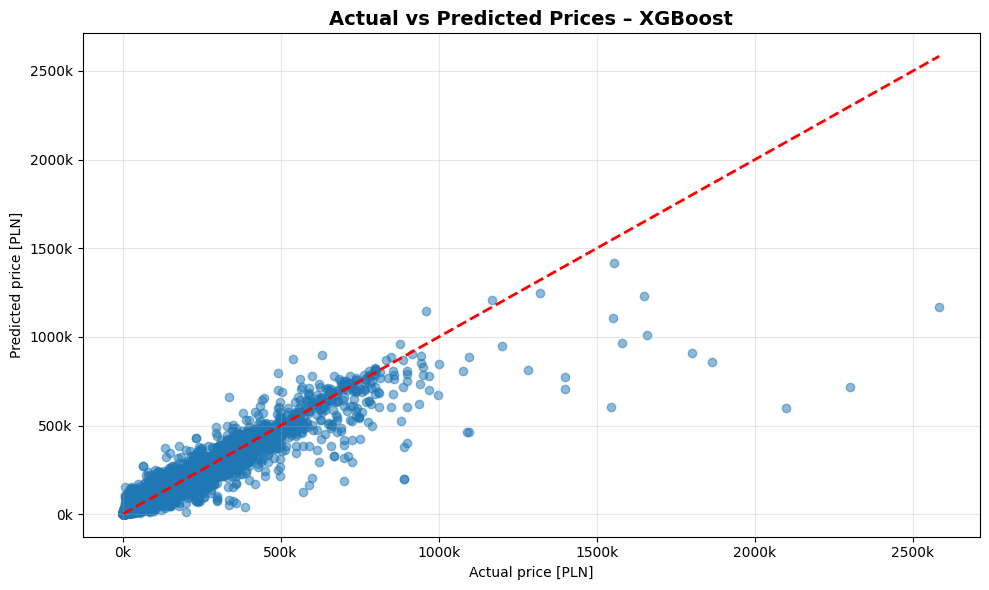

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test, y_pred_xgb, alpha=0.5)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', linewidth=2)

ax.set_xlabel("Actual price [PLN]")
ax.set_ylabel("Predicted price [PLN]")
ax.set_title("Actual vs Predicted Prices – XGBoost", fontsize=14, weight='bold')
ax.grid(alpha=0.3)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.savefig('../images/Actual_vs_Predicted_rfc', dpi=300, bbox_inches='tight')
plt.show()

The plot shows a strong linear relationship for values below 1 million, where the data points closely follow the red dashed line, indicating high model accuracy for most observations. However, for prices above approximately 1.5 million, the points start to fall below the reference line. This suggests that the model tends to underestimate the prices of the most expensive cars or specific ones.

 Overall, the model performs very well for typical price ranges but is less accurate for extreme high-value cases.

C:\Users\Przemek\AppData\Local\Temp\ipykernel_16656\3431515501.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


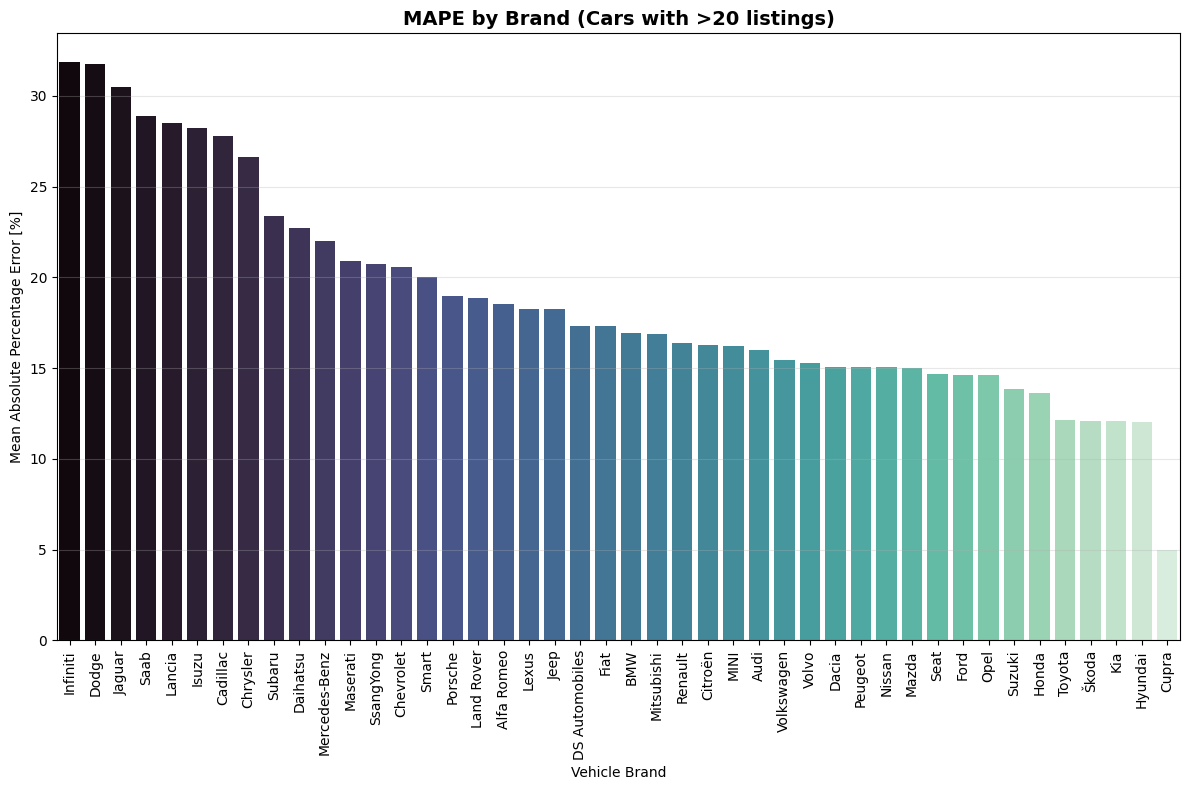

In [122]:
#Made a division to visualize MAPE in popular vs rare cars
test_df = X_test.copy()
test_df['actual'] = y_test
test_df['predicted'] = y_pred_xgb
test_df['error'] = np.abs(test_df['actual'] - test_df['predicted'])
test_df['error_pct'] = test_df['error'] / test_df['actual'] * 100

error_by_brand = test_df.groupby('Vehicle_brand')['error_pct'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
error_by_brand = error_by_brand[error_by_brand['count'] > 20]  

plt.figure(figsize=(12, 8))
error_by_brand_sorted = error_by_brand.sort_values('mean', ascending=False).reset_index()

ax = sns.barplot(
    data=error_by_brand_sorted,
    x='Vehicle_brand',
    y='mean',
    palette='mako'
)

plt.xticks(rotation=90)
plt.title('MAPE by Brand (Cars with >20 listings)', fontsize=14, weight='bold')
plt.ylabel('Mean Absolute Percentage Error [%]')
plt.xlabel('Vehicle Brand')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/MAPE_by_Brand.png', dpi=300)
plt.show()


The bar plot indicates that the Mean Absolute Percentage Error increases for more specific and less common car brands. Jaguar shows the highest error, exceeding 35%, which can be explained by its status as a luxury brand with relatively high prices and limited availability compared to mass-market brands such as BMW, Audi, Mercedes, Opel, Toyota, etc. 

Similar patterns are observed for other luxury or niche brands, including Bentley, Dodge, and Maserati, where fewer observations make accurate price prediction more challenging. Additionally, brands such as Daewoo, Lancia, and Saab are no longer in production, and the vehicles still present on the market are often older or in poorer condition. 

These factors introduce greater variability in prices, which can reduce the model’s predictive accuracy for these brands.

C:\Users\Przemek\AppData\Local\Temp\ipykernel_16656\4184000221.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


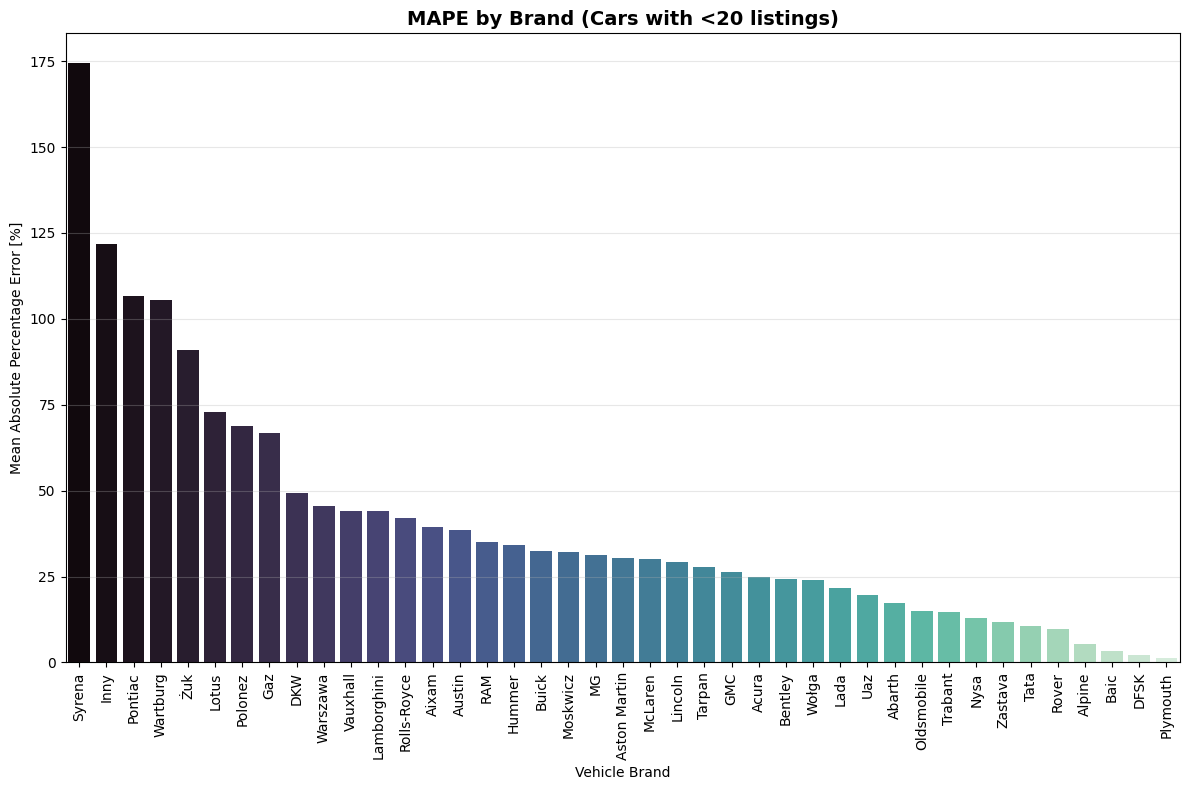

In [123]:
#Made a division to visualize MAPE in popular vs rare cars v2
test_df = X_test.copy()
test_df['actual'] = y_test
test_df['predicted'] = y_pred_xgb
test_df['error'] = np.abs(test_df['actual'] - test_df['predicted'])
test_df['error_pct'] = test_df['error'] / test_df['actual'] * 100

error_by_brand = test_df.groupby('Vehicle_brand')['error_pct'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
error_by_brand = error_by_brand[error_by_brand['count'] < 20]  

plt.figure(figsize=(12, 8))
error_by_brand_sorted = error_by_brand.sort_values('mean', ascending=False).reset_index()

ax = sns.barplot(
    data=error_by_brand_sorted,
    x='Vehicle_brand',
    y='mean',
    palette='mako'
)

plt.xticks(rotation=90)
plt.title('MAPE by Brand (Cars with <20 listings)', fontsize=14, weight='bold')
plt.ylabel('Mean Absolute Percentage Error [%]')
plt.xlabel('Vehicle Brand')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/MAPE_by_Brandv2.png', dpi=300)
plt.show()


The bar plot reveals an interesting new distribution of the data. The highest MAPE values are observed for very old vehicles, typically collector cars over 30 years old, such as Polonez, Wartburg, Pontiac, and Syrena. For these models, the error ranges from approximately 40% to almost 120%. 

In contrast, modern luxury and sports car brands—including McLaren, Ferrari, Aston Martin, and Rolls-Royce—exhibit substantially lower errors, generally below 40% but there are some which exceeded 40% error like Maybach or Lamborghini. 

A deeper analysis is required to determine how best to handle older vehicles and to understand the extent to which they influence the overall results of the model.

## Error Analysis and Model Refinement

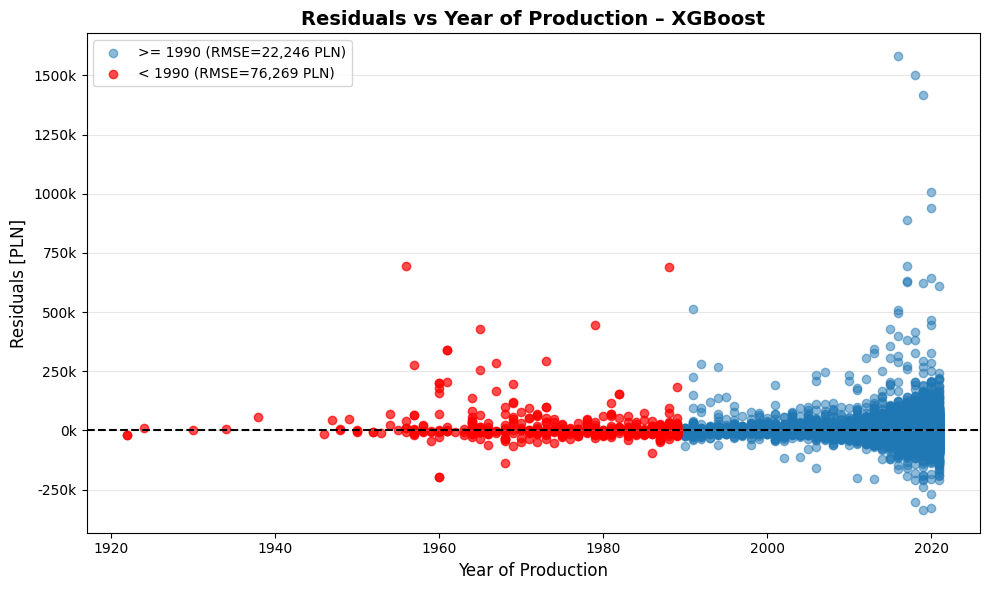

In [124]:
years = X_test['Production_year'].values
old_mask = years < 1990

rmse_old = np.sqrt(mean_squared_error(y_test[old_mask], y_pred_xgb[old_mask]))
rmse_new = np.sqrt(mean_squared_error(y_test[~old_mask], y_pred_xgb[~old_mask]))

plt.figure(figsize=(10, 6))

plt.scatter(years[~old_mask], residuals_xgb[~old_mask],
            alpha=0.5, label=f'>= 1990 (RMSE={rmse_new:,.0f} PLN)')

plt.scatter(years[old_mask], residuals_xgb[old_mask],
            color='red', alpha=0.7, label=f'< 1990 (RMSE={rmse_old:,.0f} PLN)')

plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Year of Production', fontsize=12)
plt.ylabel('Residuals [PLN]', fontsize=12)
plt.title('Residuals vs Year of Production – XGBoost', fontsize=14, weight='bold')

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.grid(axis='y', alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('../images/Residuals_vs_Year_of_Production_xgb_before_cleaning.png', dpi=300)
plt.show()

The scatter plot confirms the relationship between car production year and price prediction errors. Cars produced before 1990 tend to exhibit higher residuals, which is consistent with the MAPE analysis. Although only a limited number of older cars show very large residuals, vehicles manufactured between 1960 and 1980 are often overestimated by the model.

On the other hand, modern supercars such as Ferrari, Bentley, or Lamborghini also display relatively high MAPE values and large residuals, as shown in the charts. These brands are represented by only a small number of observations, and their prices are extremely high, which may lead the model to misinterpret brand-specific pricing patterns.

Overall, it may be a good idea to exclude cars produced before 1980, as well as supercars that constitute at most about 1% of the total car market offers, in order to improve model stability and predictive performance.

In [125]:
#According to the description let's cut some values
cars_data_refined = cars_data_drop_copy.copy()

#Cutting cars that production year are below 1980 
cars_data_refined = cars_data_refined[cars_data_refined['price_PLN'] > 1980]

#Exploring the price threshold corresponding to the top 1% most expensive cars
#and removing those observations from the dataset
price_to_cut = cars_data_refined['price_PLN'].quantile(0.99)
cars_data_refined = cars_data_refined[cars_data_refined['price_PLN'] < price_to_cut]

In [126]:
X = cars_data_refined.drop('price_PLN', axis=1)
y = cars_data_refined['price_PLN']

In [127]:
#train_test_split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.3 ,random_state=42)

In [128]:
global_median_power = X_train_new['Power_HP'].median()
power_map = X_train_new.groupby('Vehicle_model')['Power_HP'].median()

global_median_disp = X_train_new['Displacement_cm3'].median()
disp_map = X_train_new.groupby('Vehicle_model')['Displacement_cm3'].median()

global_median_mileage = X_train_new['Mileage_km'].median()
mileage_map = X_train_new.groupby('Vehicle_model')['Mileage_km'].median()

drive_map = X_train_new.groupby('Vehicle_model')['Drive'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
)

def smart_fill(df, col_name, mapping, global_fallback=None):
    df = df.copy()
    
    filled_values = df['Vehicle_model'].map(mapping)
    
    df[col_name] = df[col_name].fillna(filled_values)
    
    if global_fallback is not None:
        df[col_name] = df[col_name].fillna(global_fallback)
    else:
        df[col_name] = df[col_name].fillna('Unknown')
        
    return df[col_name] 

X_train_new['Power_HP'] = smart_fill(X_train_new, 'Power_HP', power_map, global_median_power)
X_train_new['Displacement_cm3'] = smart_fill(X_train_new, 'Displacement_cm3', disp_map, global_median_disp)
X_train_new['Drive'] = smart_fill(X_train_new, 'Drive', drive_map)
X_train_new['Mileage_km'] = smart_fill(X_train_new, 'Mileage_km', mileage_map, global_median_mileage)

X_test_new['Power_HP'] = smart_fill(X_test_new, 'Power_HP', power_map, global_median_power)
X_test_new['Displacement_cm3'] = smart_fill(X_test_new, 'Displacement_cm3', disp_map, global_median_disp)
X_test_new['Drive'] = smart_fill(X_test_new, 'Drive', drive_map)
X_test_new['Mileage_km'] = smart_fill(X_test_new, 'Mileage_km', mileage_map, global_median_mileage)

In [129]:
pipeline_xgb_cleaned = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('model', xgb.XGBRegressor(random_state=42))
])

In [130]:
y_train_log_cleaned = np.log1p(y_train_new)
y_test_log_cleaned = np.log1p(y_test_new)

In [131]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

In [132]:
best_params_cleaned = study.best_params
pipeline_xgb_cleaned.set_params(**{f"model__{k}": v for k, v in best_params.items()})

pipeline_xgb_cleaned.fit(X_train_new, y_train_log_cleaned)

y_pred_xgb_log_cleaned = pipeline_xgb_cleaned.predict(X_test_new)
y_pred_xgb_cleaned = np.expm1(y_pred_xgb_log_cleaned)

In [133]:
#Metrics for cleaned XGBoost
test_metrics_xgb_cleaned = metrics(y_test_new, y_pred_xgb_cleaned)
test_metrics_xgb_cleaned_df = pd.DataFrame({
    'Test': test_metrics_xgb_cleaned
})

test_metrics_xgb_cleaned_df = pd.DataFrame(list(test_metrics_xgb_cleaned.items()), columns=['Metric', 'Value'])
test_metrics_xgb_cleaned_df

,Metric,Value
0,R2,0.943277
1,RMSE,14149.996193
2,MAE,6838.356228
3,MAPE,0.158401


The model shows strong overall performance, achieving an R² score of 94.3%, little bit better than XGBoost before cleaning, which indicates that it explains most of the variance in car prices. The RMSE of 14,142 suggests that larger errors still occur, mainly for high-priced or rare vehicles but they are reduced by removing some old, rare cars and most supercars. The MAE of 6,695 indicates that, on average, predictions deviate from actual prices by about seven thousand units. A MAPE of 16.2% shows that relative errors are generally moderate and acceptable for this type of market data. Overall, the model performs reliably but struggles with extreme or niche cases.

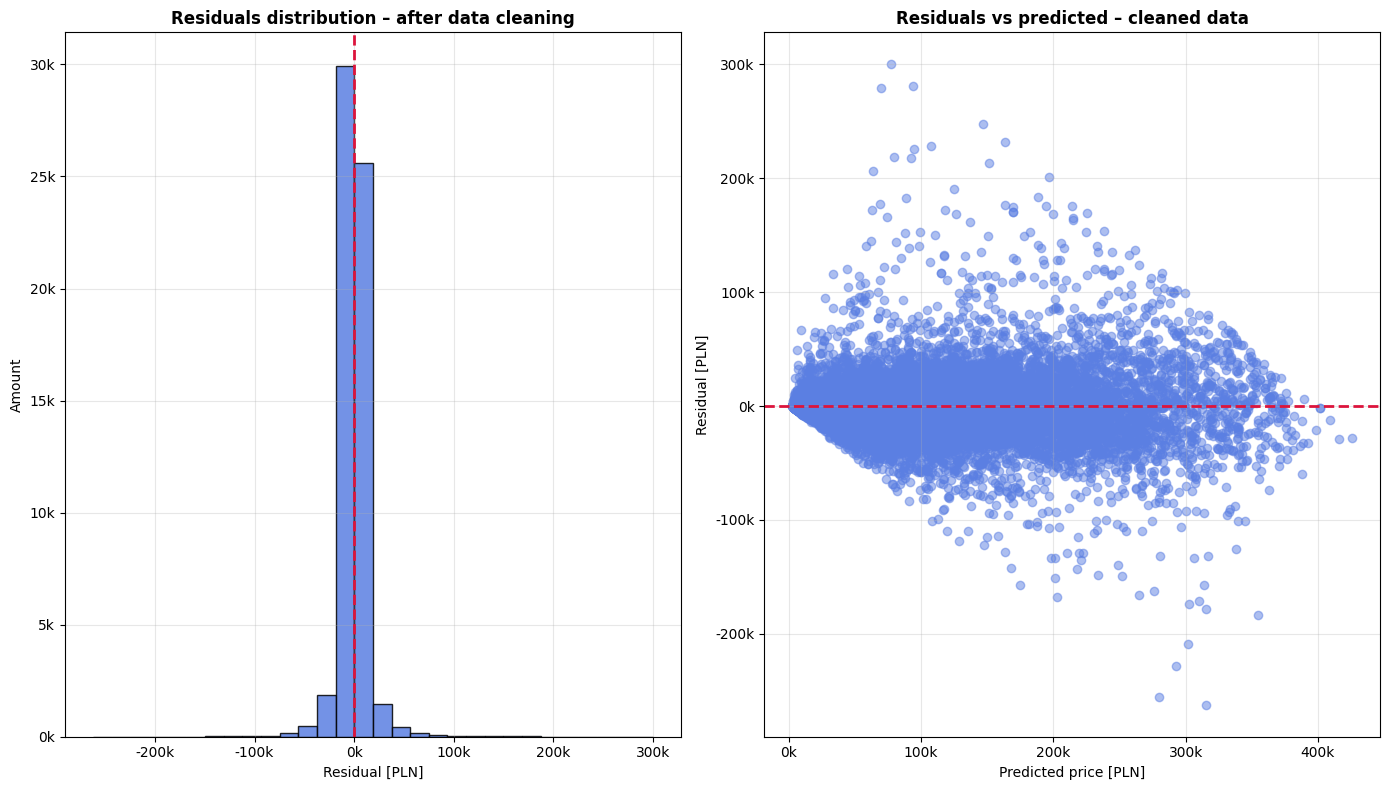

In [134]:
residuals_xgb_cleaned = y_test_new - y_pred_xgb_cleaned
rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_xgb_cleaned))
mae = mean_absolute_error(y_test_new, y_pred_xgb_cleaned)

fig, ax = plt.subplots(1, 2, figsize=(14,8))

# Histogram
ax[0].hist(residuals_xgb_cleaned, bins=30, color="#5B7FE2", edgecolor='black', alpha=0.85)
ax[0].axvline(0, color='crimson', linestyle='--', linewidth=2)
ax[0].set_title("Residuals distribution – after data cleaning", fontsize=12, weight='bold')
ax[0].set_xlabel("Residual [PLN]")
ax[0].set_ylabel("Amount")
ax[0].grid(alpha=0.3)

ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

# Scatter
ax[1].scatter(y_pred_xgb_cleaned, residuals_xgb_cleaned, alpha=0.5, color="#5B7FE2")
ax[1].axhline(0, color='crimson', linestyle='--', linewidth=2)
ax[1].set_title("Residuals vs predicted – cleaned data", fontsize=12, weight='bold')
ax[1].set_xlabel("Predicted price [PLN]")
ax[1].set_ylabel("Residual [PLN]")
ax[1].grid(alpha=0.3)

ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.savefig('../images/Residuals_diagnostics_xgb_cleaned.png', dpi=300)
plt.show()

Distribution of Residuals: The final histogram shows a tall, narrow bell curve centered near zero. This indicates that, for the vast majority of cases, the model's errors are small, symmetrical, and approximately normally distributed. The scatter plot on the right confirms that, while variance slightly increases for higher-priced cars (heteroscedasticity), the model remains unbiased and stable.

Residuals vs. Predicted Values: The residuals form a dense cloud clustered around the red line, showing that errors are lower than in previous versions of the model. Previously, some residuals exceeded 1 million zloty, which was extremely high. Now, the maximum errors are around 300k zloty, while most residuals are concentrated between +/-50k zloty, indicating improved model accuracy and stability.

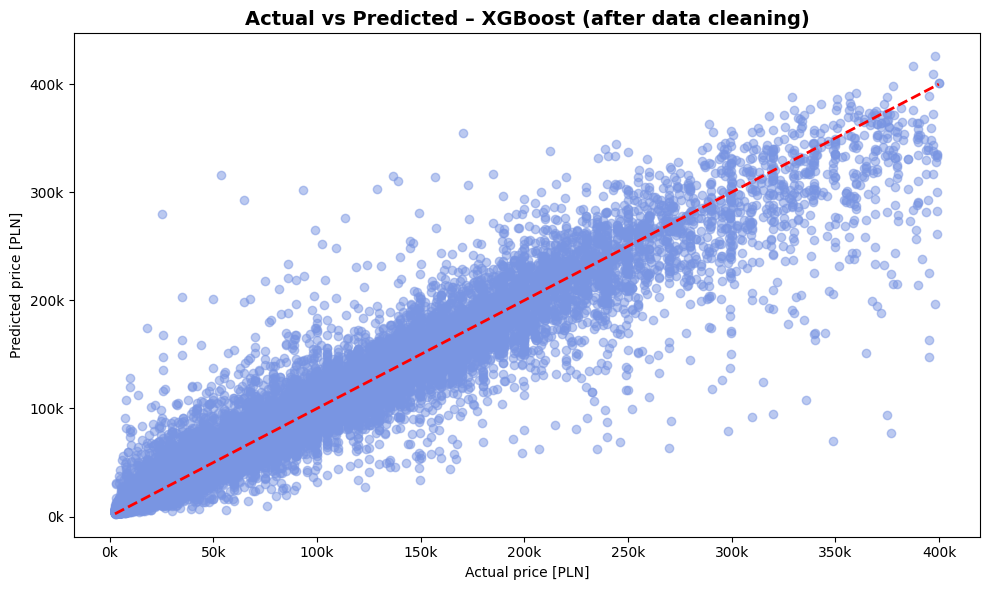

In [135]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(y_test_new, y_pred_xgb_cleaned, alpha=0.5, color="#7995E2")
ax.plot([y_test_new.min(), y_test_new.max()],
        [y_test_new.min(), y_test_new.max()],
        'r--', linewidth=2)

ax.set_xlabel("Actual price [PLN]")
ax.set_ylabel("Predicted price [PLN]")
ax.set_title("Actual vs Predicted – XGBoost (after data cleaning)", fontsize=14, weight='bold')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.savefig('../images/Actual_vs_Predicted_xgb_cleaned.png', dpi=300)
plt.show()

The Actual vs. Predicted Values chart shows that most points are closely clustered around the red line, indicating good model performance. A few points lie slightly farther from the line, but these deviations are smaller than in the previous version of the XGBoost model. The chart also highlights that rare, special, and supercars are the main contributors to larger prediction errors, as their prices are extreme and less represented in the dataset.

C:\Users\Przemek\AppData\Local\Temp\ipykernel_16656\1522245068.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


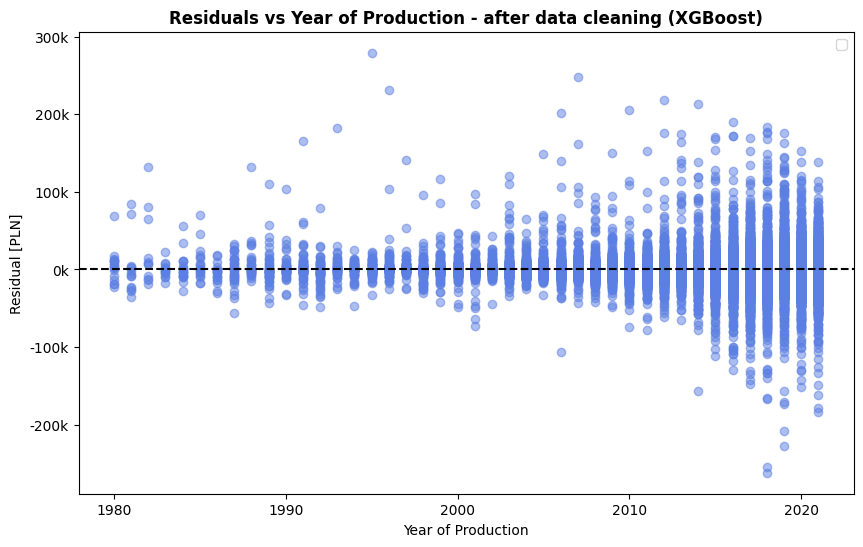

In [136]:
years_new = X_test_new['Production_year'].values
old_mask = years_new < 1980

plt.figure(figsize=(10, 6))
plt.scatter(years_new[~old_mask], residuals_xgb_cleaned[~old_mask], alpha=0.5, color="#5B7FE2")

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Year of Production')
plt.ylabel('Residual [PLN]')
plt.title('Residuals vs Year of Production - after data cleaning (XGBoost)', weight = 'bold')

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.legend()
plt.savefig('../images/Residuals_vs_Year_of_Production_for_xgb_cleaned', dpi=300, bbox_inches='tight')
plt.show()

The scatter plot shows residuals vs. year of production. Most residuals are clustered around zero, indicating that the model generally predicts well across different production years. However, the spread of residuals increases for more recent cars, suggesting slightly higher variance in predictions for newer models. Some points deviate significantly above and below zero, likely corresponding to rare, special, or high-value cars, which the model struggles to predict accurately. Older cars (before the 1990s) appear to have smaller residuals overall, while extreme errors are more visible in both very new cars and certain older collectible models.

In [139]:
#Saving XGBoost model
joblib.dump(pipeline_xgb_cleaned, '../models/XGBoost_model.joblib')

['../models/XGBoost_model.joblib']

### Conclusions on XGBoost Models

The initial XGBoost model improved the overall prediction performance compared to the previous models, slightly enhancing all evaluation metrics. The distribution histogram and scatterplots indicate that most predicted values are close to the actual car prices, demonstrating good general accuracy. However, the model still produced several extreme outliers, with prediction errors reaching up to 1.5 million PLN. Further analysis using the Residuals vs. Year of Production scatterplot revealed that these outliers were primarily caused by very old, rare vehicles (mostly produced before 1980) as well as modern supercars.

After removing vehicles produced before 1980 and excluding the top 1% most expensive cars, the model’s performance improved significantly. The $R^2$ score increased slightly by approximately 0.3%, while error metrics decreased substantially, with RMSE dropping from 21,019 PLN to 14,726 PLN and MAE from 7,672 PLN to 7,023 PLN. These improvements indicate that the model now predicts car prices with lower error and reduced sensitivity to extreme cases. The updated scatterplots confirm better model calibration, with predictions more tightly clustered around the reference line and maximum errors reduced to approximately 300,000 PLN—previously up to five times larger. Overall, the final tuned and cleaned XGBoost model achieved the best performance among all tested models, significantly reducing large outliers and providing more accurate and reliable predictions, which would likely result in higher satisfaction for future users.

### Models Comparision

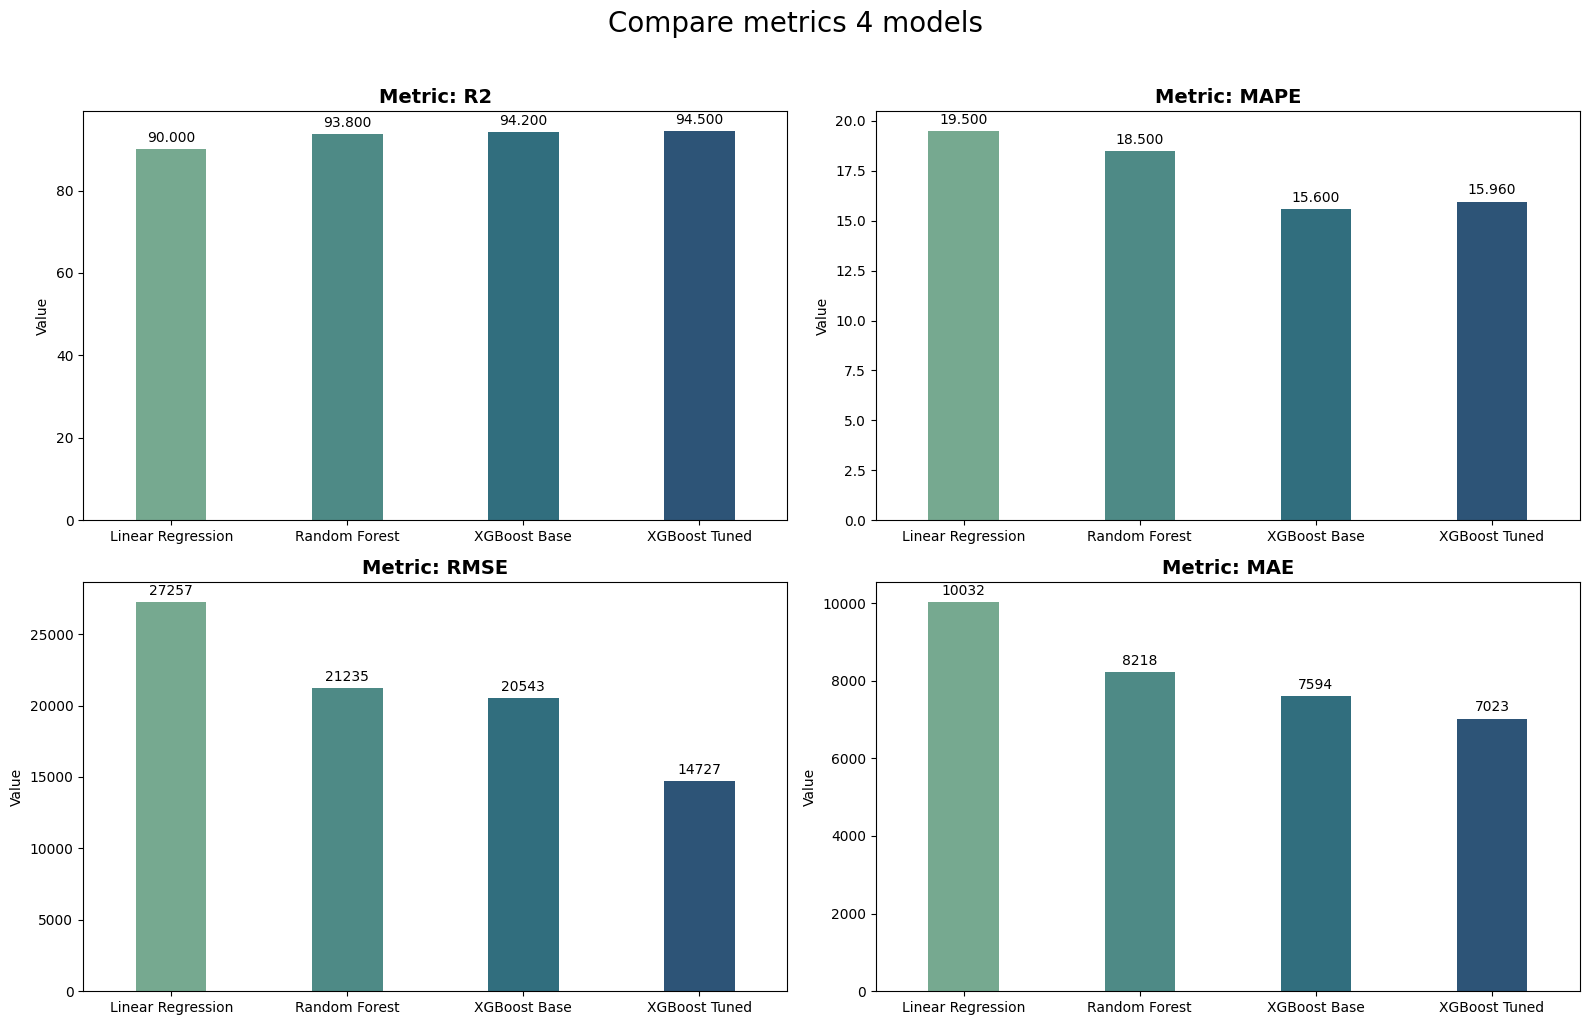

In [138]:
data_model_1 = {'R2': 90, 'RMSE': 27257, 'MAE': 10032, 'MAPE': 19.5}
data_model_2 = {'R2': 93.8, 'RMSE': 21235, 'MAE': 8218, 'MAPE': 18.5}
data_model_3 = {'R2': 94.2, 'RMSE': 20543, 'MAE': 7594, 'MAPE': 15.6}
data_model_4 = {'R2': 94.5, 'RMSE': 14727, 'MAE': 7023, 'MAPE': 15.96}

models_data = [
    ('Linear Regression', data_model_1),
    ('Random Forest', data_model_2),
    ('XGBoost Base', data_model_3),
    ('XGBoost Tuned', data_model_4)
]

dfs = []
for model_name, metrics_dict in models_data:
    temp_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    temp_df['Model'] = model_name
    dfs.append(temp_df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['Value'] = pd.to_numeric(df_all['Value'])

metrics_to_plot = ['R2', 'MAPE', 'RMSE', 'MAE']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten() 

for i, metric in enumerate(metrics_to_plot):
    
    subset = df_all[df_all['Metric'] == metric]
    
    sns.barplot(
        data=subset, 
        x='Model', 
        y='Value', 
        hue='Model',       
        palette='crest', 
        ax=axes[i],  
        width=0.4,     
        dodge=False        
    )
    
    axes[i].set_title(f'Metric: {metric}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('') 
    axes[i].set_ylabel('Value')
    
    fmt = '%.3f' if metric in ['R2', 'MAPE'] else '%.0f' 
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt=fmt, padding=3)

    if axes[i].get_legend():
        axes[i].get_legend().remove()

plt.suptitle('Compare metrics 4 models', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

Linear Regression performed the worst among all tested models (MAE ≈ 10,000 PLN) because car price depreciation is inherently non-linear. New vehicles lose value much more rapidly than older ones, a pattern that linear models cannot capture effectively. In contrast, more complex algorithms such as Random Forest and XGBoost naturally model non-linear relationships and feature interactions—for example, high mileage has a significantly greater impact on newer cars than on older ones.

The most notable improvement is the substantial reduction in RMSE from approximately 20,500 PLN in the base XGBoost model to about 14,800 PLN in the tuned version. Since RMSE heavily penalizes large prediction errors, this decrease indicates that the applied data-cleaning strategy—removing vintage cars produced before 1980 and extreme luxury outliers priced above 1.5 million PLN—successfully eliminated observations that previously distorted model performance.

The final XGBoost model achieved a notably low MAPE of around 15.96%, outperforming both Linear Regression (≈19.5%) and Random Forest (≈18.5%). Additionally, the $R^2$ score reached an excellent level of approximately 94.5% for both XGBoost models, compared to 90% for Linear Regression, confirming the latter’s limited suitability for this task.

Overall, the final model is not only more accurate on average, as reflected by the lowest MAE, but also significantly more stable and reliable, demonstrated by the lowest RMSE among all evaluated models.

## Project Summary: Car Price Prediction

Project Objective The primary goal of this project was to develop a robust machine learning model capable of accurately predicting car prices. The study evaluated multiple algorithms—including Linear Regression, Random Forest, and XGBoost—combined with rigorous data refinement and hyperparameter tuning to maximize predictive performance.

Methodology & Results After extensive experimentation, the tuned XGBoost model was selected as the final solution, achieving the best overall evaluation metrics.

  - Performance: The model demonstrates excellent stability and accuracy for the medium price segment, which represents the majority of the dataset.

  - Comparative Analysis: XGBoost outperformed the baseline Linear Regression and Random Forest models, effectively capturing non-linear relationships in the data.

Limitations & Challenges While the model generalizes well for standard vehicles, significant deviations remain in the luxury and supercar segments.

  - High Variance: Predictions for rare, special edition, or high-performance vehicles occasionally show errors exceeding several hundred thousand PLN.

  - Root Cause: These segments are characterized by lower data volume and high price volatility driven by subjective features (e.g., collector status, unique configurations) that are difficult for the model to quantify.

Future Work To address the challenges in the high-value segment, future iterations of the project will focus on:

1. Model Segmentation: Training separate models for economy/medium cars and luxury/supercars to prevent high-variance outliers from skewing the main predictions.

2. Feature Engineering: Incorporating more granular data specific to luxury vehicles (e.g., trim packages, limited edition flags).

3. Target Transformation: Experimenting with Log-transformation to stabilize variance across price ranges.